# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados do Experimento Univariado com Regressão Múltipla para a Previsão de 2013 

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Análise Univariada de Regressão Múltipla da Série de Arrecadação do ICMS Paulista 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(15,8)})

2023-08-21 16:07:46.094605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

date       icms_sp    igp_m   dolar  ibc_br  dias_uteis  igp_m_22  \
0 2003-01-01  3.360296e+09  277.173  3.4384   96.15          22   277.173   
1 2003-02-01  3.196558e+09  283.506  3.5908   98.67          20   283.506   
2 2003-03-01  3.160011e+09  287.855  3.4469  103.41          19   287.855   
3 2003-04-01  3.215307e+09  290.512  3.1187  102.19          20   290.512   
4 2003-05-01  3.098930e+09  289.747  2.9557  100.30          21   289.747   

   dolar_22  ibc_br_22  igp_m_21  ...  ibc_br_16  igp_m_15  dolar_15  \
0    3.4384      96.15   277.173  ...      96.15   277.173    3.4384   
1    3.5908      98.67   283.506  ...      98.67   283.506    3.5908   
2    3.4469     103.41   287.855  ...     103.41   287.855    3.4469   
3    3.1187     102.19   290.512  ...     102.19   290.512    3.1187   
4    2.9557     100.30   289.747  ...     100.30   289.747    2.9557   

   ibc_br_15  igp_m_14  dolar_14  ibc_br_14  igp_m_13  dolar_13  ibc_br_13  
0      96.15   277.173    3.4384      96.15   277.173    3.4384      96.15  
1      98.67   283.506    3.5908      98.67   283.506    3.5908      98.67  
2     103.41   287.855    3.4469     103.41   287.855    3.4469     103.41  
3     102.19   290.512    3.1187     102.19   290.512    3.1187     102.19  
4     100.30   289.747    2.9557     100.30   289.747    2.9557     100.30  

[5 rows x 36 columns]

In [5]:
df_main_orig.tail()

date       icms_sp     igp_m     dolar  ibc_br  dias_uteis  \
235 2022-08-01  1.756224e+10  1185.004  5.143287  149.60          23   
236 2022-09-01  1.726287e+10  1173.793  5.236957  144.44          21   
237 2022-10-01  1.565000e+10  1162.391  5.250300  142.34          20   
238 2022-11-01  1.605000e+10  1155.829  5.274650  140.80          20   
239 2022-12-01  1.767135e+10  1161.006  5.242432  142.78          22   

        igp_m_22  dolar_22   ibc_br_22  igp_m_21  ...  ibc_br_16  igp_m_15  \
235  1137.167829    5.6496  146.408337       NaN  ...        NaN       NaN   
236  1143.597376    5.6800  142.808302       NaN  ...        NaN       NaN   
237  1150.115881    5.6700  144.063428       NaN  ...        NaN       NaN   
238  1155.866460    5.6000  143.165409       NaN  ...        NaN       NaN   
239  1161.645792    5.6000  141.405133       NaN  ...        NaN       NaN   

     dolar_15  ibc_br_15  igp_m_14  dolar_14  ibc_br_14  igp_m_13  dolar_13  \
235       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
236       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
237       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
238       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
239       NaN        NaN       NaN       NaN        NaN       NaN       NaN   

     ibc_br_13  
235        NaN  
236        NaN  
237        NaN  
238        NaN  
239        NaN  

[5 rows x 36 columns]

In [6]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as últimas linhas que são todas NaN

In [7]:
df_main = df_main_orig.iloc[0:132]
datas = df_main['date']

In [8]:
df_main.tail()

date       icms_sp    igp_m     dolar  ibc_br  dias_uteis  igp_m_22  \
127 2013-08-01  9.604407e+09  521.270  2.342191  151.81          22   521.270   
128 2013-09-01  1.011536e+10  529.085  2.270510  147.27          21   529.085   
129 2013-10-01  1.020979e+10  533.621  2.188648  151.90          23   533.621   
130 2013-11-01  9.712795e+09  535.168  2.295350  147.79          20   535.168   
131 2013-12-01  1.076762e+10  538.370  2.345486  145.77          21   538.370   

     dolar_22  ibc_br_22  igp_m_21  ...  ibc_br_16  igp_m_15  dolar_15  \
127  2.342191     151.81   521.270  ...     151.81   521.270  2.342191   
128  2.270510     147.27   529.085  ...     147.27   529.085  2.270510   
129  2.188648     151.90   533.621  ...     151.90   533.621  2.188648   
130  2.295350     147.79   535.168  ...     147.79   535.168  2.295350   
131  2.345486     145.77   538.370  ...     145.77   538.370  2.345486   

     ibc_br_15  igp_m_14  dolar_14  ibc_br_14    igp_m_13  dolar_13  \
127     151.81   521.270  2.342191     151.81  527.544908      2.07   
128     147.27   529.085  2.270510     147.27  530.024369      2.07   
129     151.90   533.621  2.188648     151.90  532.833498      2.07   
130     147.79   535.168  2.295350     147.79  535.497666      2.08   
131     145.77   538.370  2.345486     145.77  537.907405      2.09   

      ibc_br_13  
127  152.985410  
128  148.834167  
129  151.727873  
130  149.174166  
131  145.576261  

[5 rows x 36 columns]

### Criação das Séries
Como os valores do ICMS são muito elevados a série será colocada em log.

In [9]:
icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)
ibcbr_ts = pd.Series(list(df_main['ibc_br']), index = datas)
igpm_ts = pd.Series(list(df_main['igp_m']), index = datas)
dolar_ts = pd.Series(list(df_main['dolar']), index = datas)
dias_uteis_ts = pd.Series(list(df_main['dias_uteis']), index = datas)
igpm_prev_ts = pd.Series(list(df_main['igp_m_13']), index = datas)
ibcbr_prev_ts = pd.Series(list(df_main['ibc_br_13']), index = datas)
dolar_prev_ts = pd.Series(list(df_main['dolar_13']), index = datas)

#### Testes de Valores Nulos

In [10]:
print('ICMS', icms_ts.isnull().sum())
print('IBC-Br', ibcbr_ts.isnull().sum())
print('IGP-DI', igpm_ts.isnull().sum())
print('Dólar', dolar_ts.isnull().sum())
print('Dias Úteis', dias_uteis_ts.isnull().sum())
print('IGP-M Previsão', igpm_prev_ts.isnull().sum())
print('IBC-Br Previsão', ibcbr_prev_ts.isnull().sum())
print('Dólar Previsão', dolar_prev_ts.isnull().sum())

ICMS 0
IBC-Br 0
IGP-DI 0
Dólar 0
Dias Úteis 0
IGP-M Previsão 0
IBC-Br Previsão 0
Dólar Previsão 0


### Plotando a Série em Nível

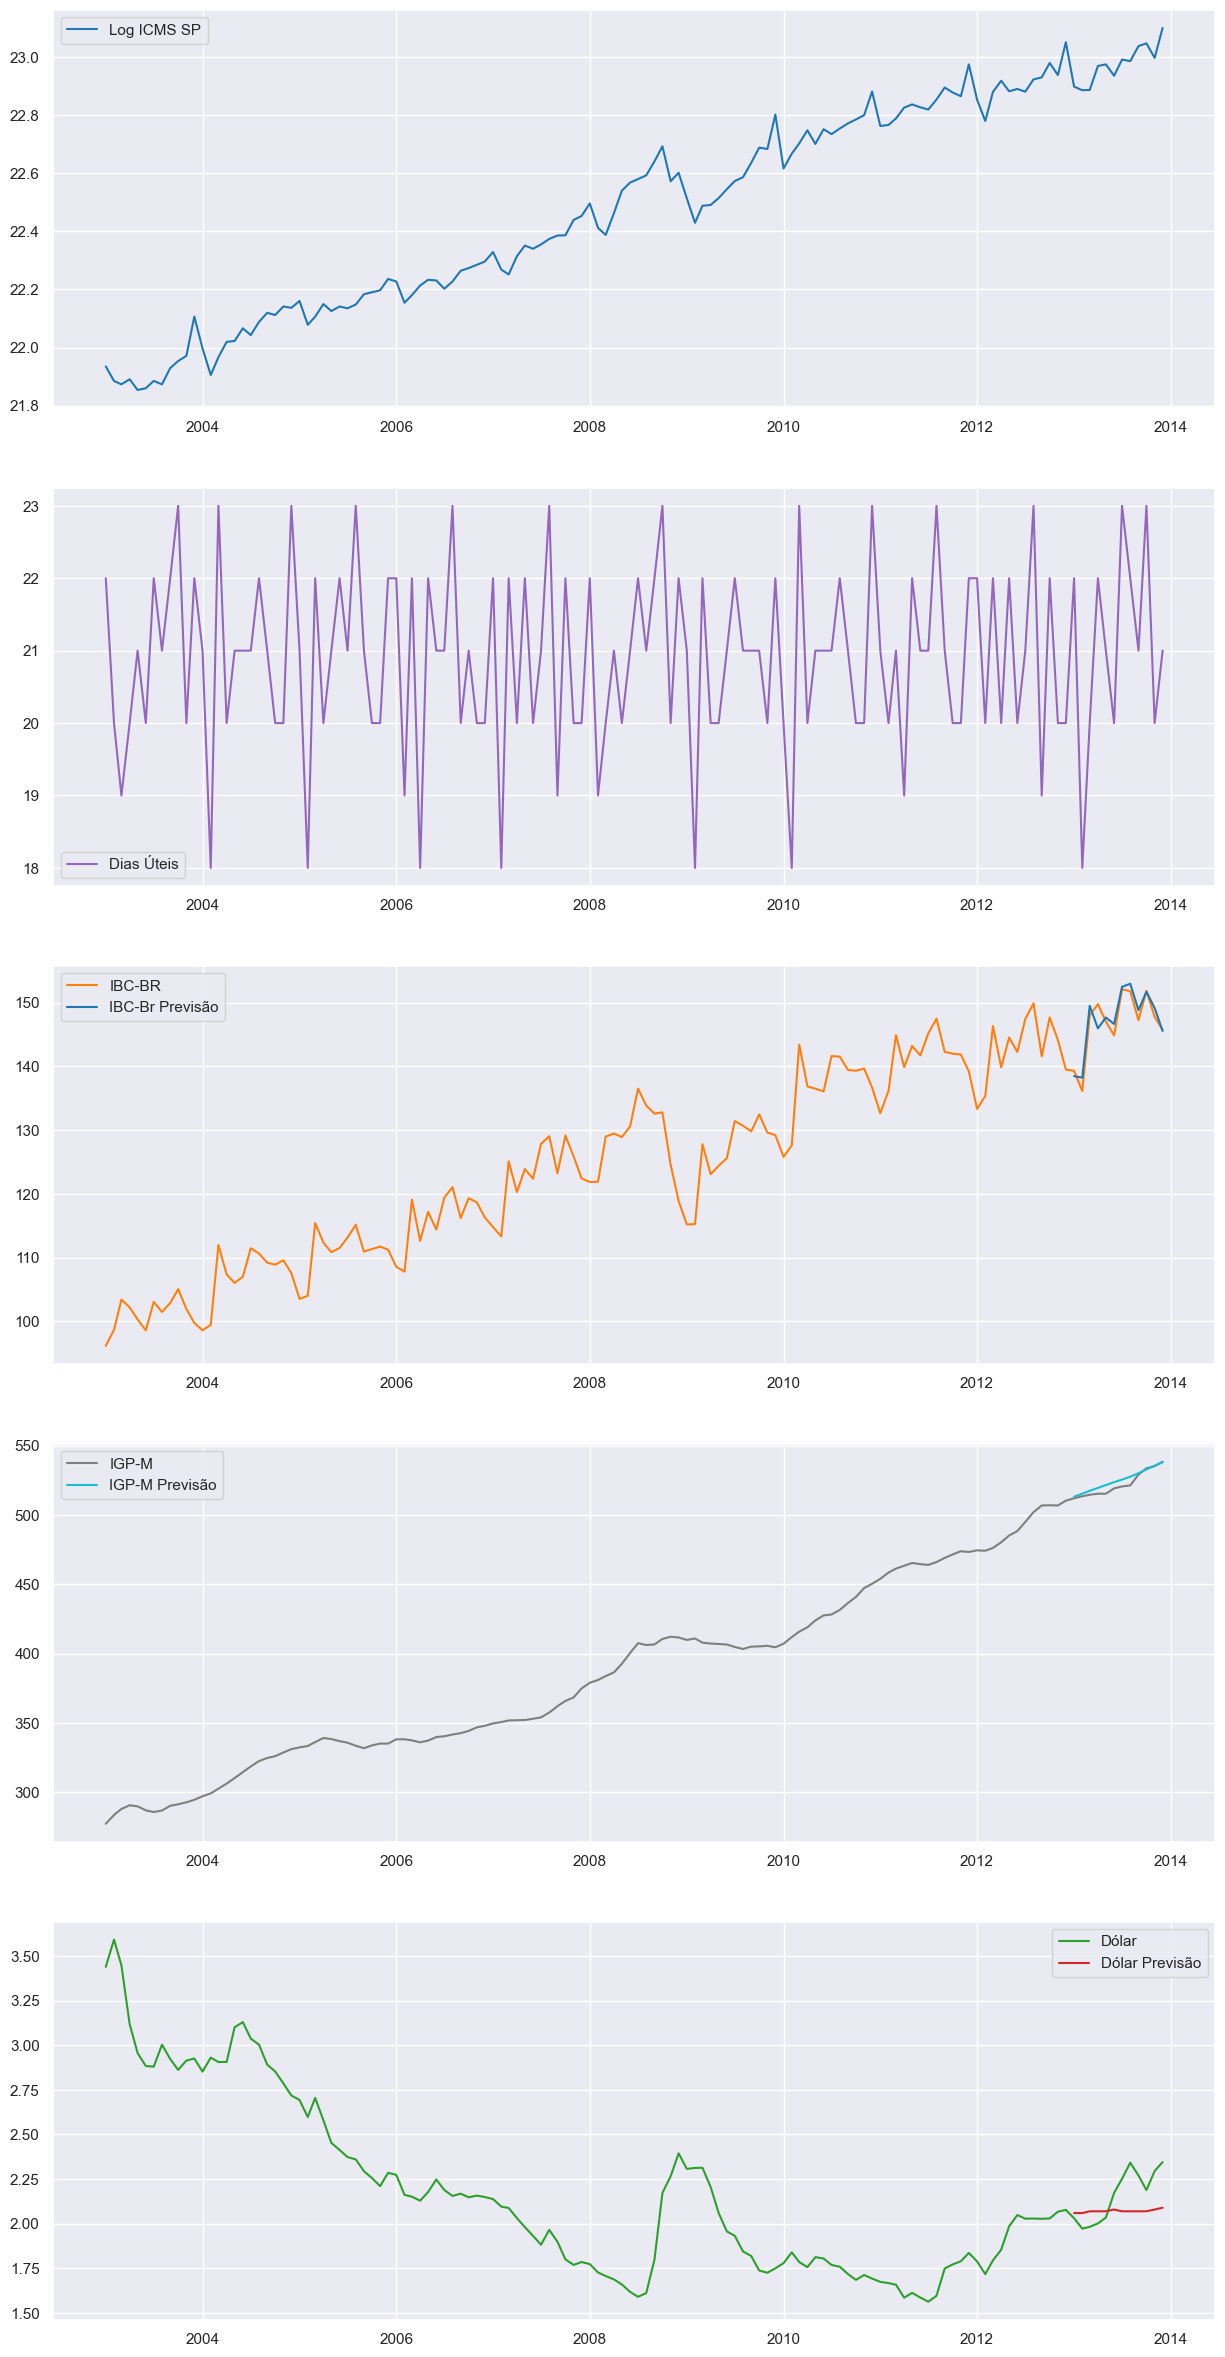

In [11]:
fig=plt.figure(figsize=(15, 30))
ax1=fig.add_subplot(511)
ax2=fig.add_subplot(512)
ax3=fig.add_subplot(513)
ax4=fig.add_subplot(514)
ax5=fig.add_subplot(515)
#plots
ax1.plot(icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts, 'tab:orange',  label='IBC-BR')
ax3.legend(loc='best')
ax3.plot(ibcbr_prev_ts[-12:], 'tab:blue', label='IBC-Br Previsão')
ax3.legend(loc='best')
ax4.plot(igpm_ts, 'tab:gray', label='IGP-M')
ax4.legend(loc='best')
ax4.plot(igpm_prev_ts[-12:], 'tab:cyan',  label='IGP-M Previsão')
ax4.legend(loc='best')
ax5.plot(dolar_ts, 'tab:green', label='Dólar')
ax5.legend(loc='best')
ax5.plot(dolar_prev_ts[-12:], 'tab:red', label='Dólar Previsão')
ax5.legend(loc='best')
plt.show()

### Séries em Primeira Diferença

In [12]:
icms_ts_d1 = icms_ts.diff().dropna()
ibcbr_ts_d1 = ibcbr_ts.diff().dropna()
igpm_ts_d1 = igpm_ts.diff().dropna()
dolar_ts_d1 = dolar_ts.diff().dropna()
dias_uteis_ts_d1 = dias_uteis_ts.diff().dropna()
igpm_prev_ts_d1 = igpm_prev_ts.diff().dropna()
ibcbr_prev_ts_d1 = ibcbr_prev_ts.diff().dropna()
dolar_prev_ts_d1 = dolar_prev_ts.diff().dropna()

### Séries em Segunda Diferença

In [13]:
icms_ts_d2 = icms_ts_d1.diff().dropna()
ibcbr_ts_d2 = ibcbr_ts_d1.diff().dropna()
igpm_ts_d2 = igpm_ts_d1.diff().dropna()
dolar_ts_d2 = dolar_ts_d1.diff().dropna()
dias_uteis_ts_d2 = dias_uteis_ts_d1.diff().dropna()
igpm_prev_ts_d2 = igpm_prev_ts_d1.diff().dropna()
ibcbr_prev_ts_d2 = ibcbr_prev_ts_d1.diff().dropna()
dolar_prev_ts_d2 = dolar_prev_ts_d1.diff().dropna()

### Plotando as Séries em Primeira Diferença

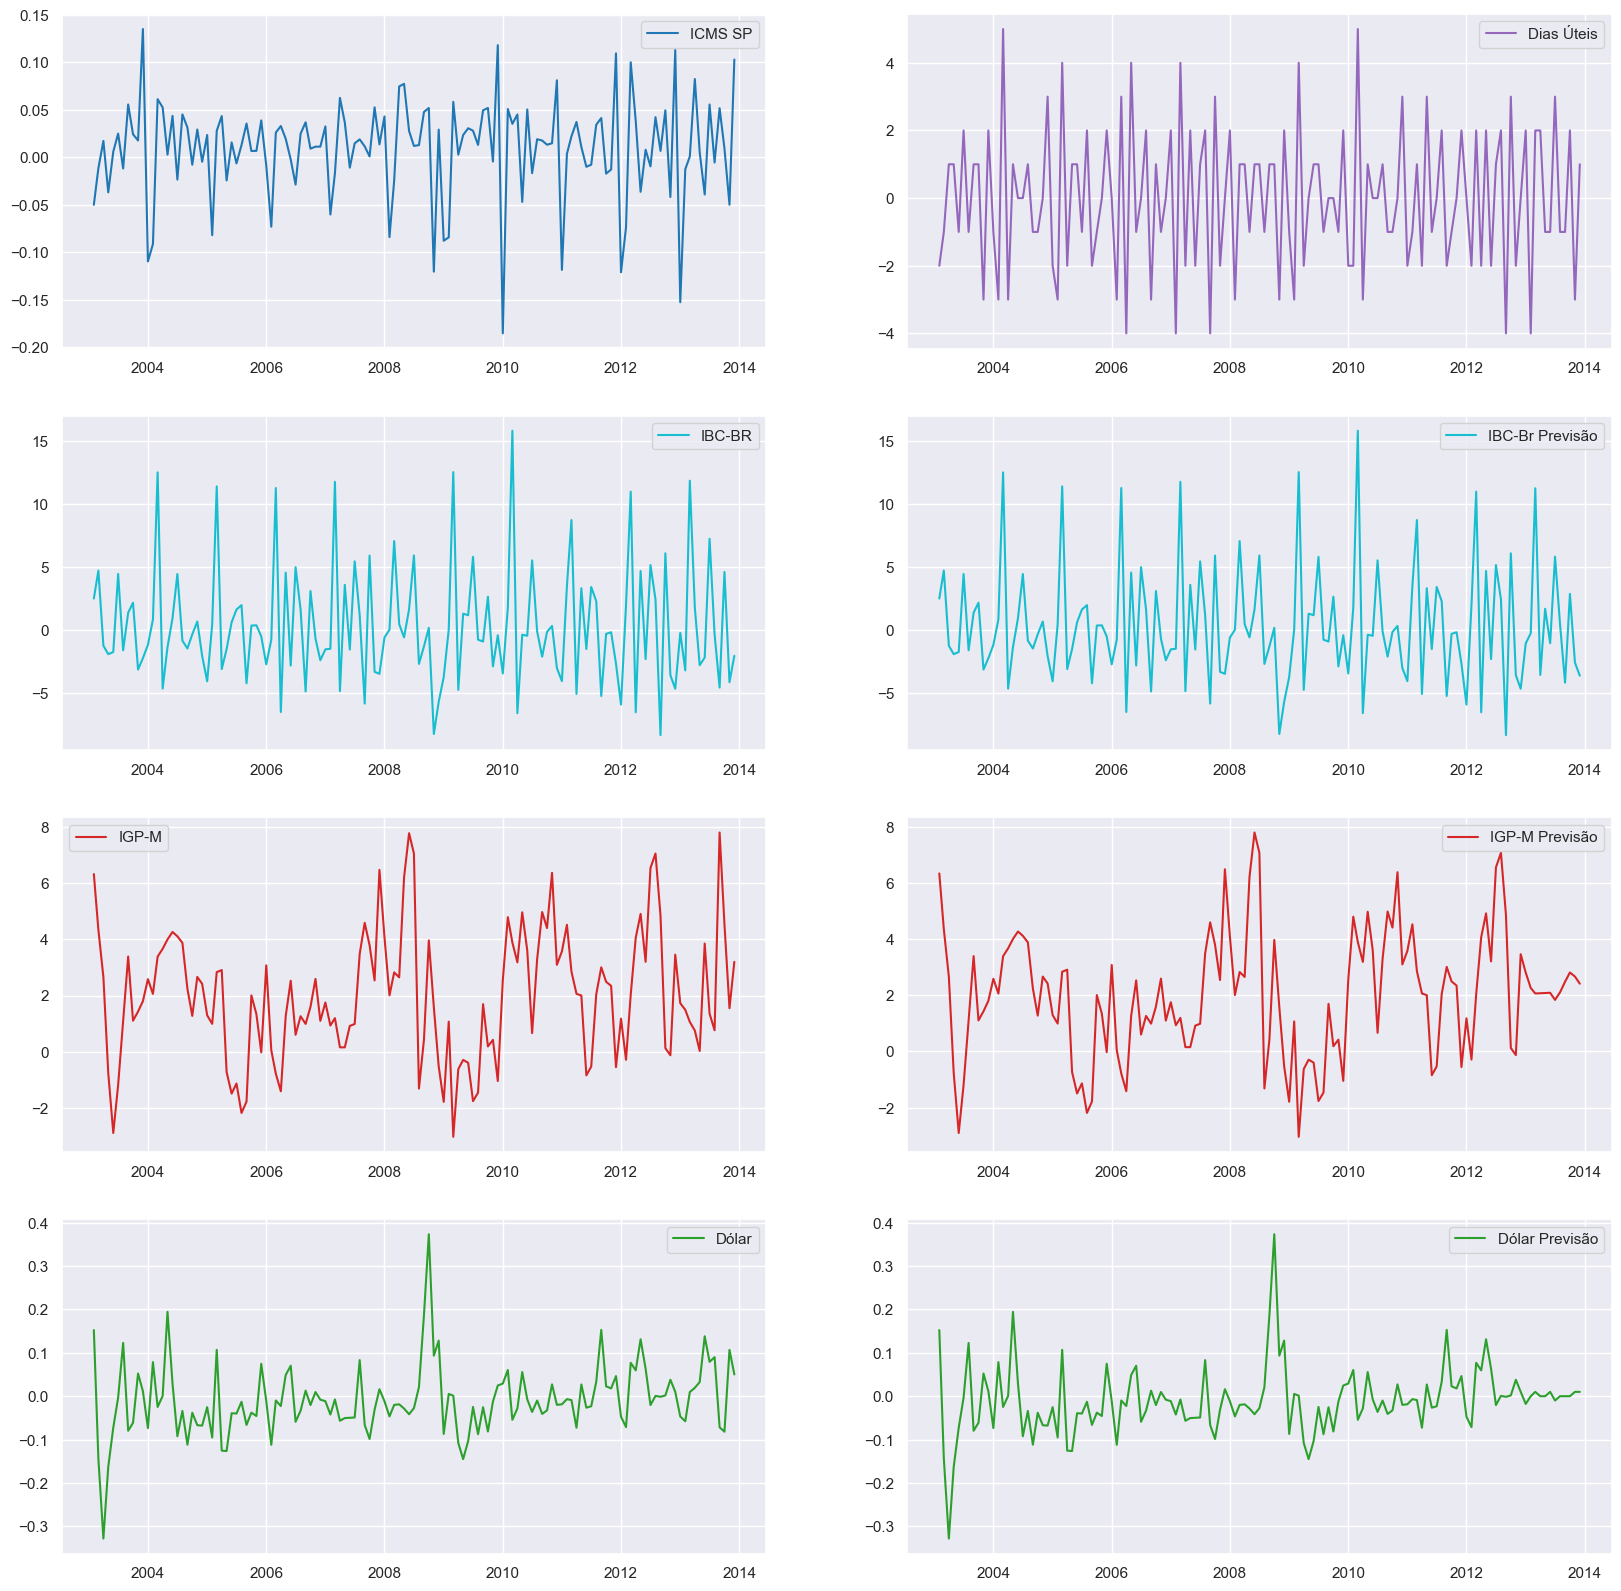

In [14]:
fig=plt.figure(figsize=(20, 20))
ax1=fig.add_subplot(421)
ax2=fig.add_subplot(422)
ax3=fig.add_subplot(423)
ax4=fig.add_subplot(424)
ax5=fig.add_subplot(425)
ax6=fig.add_subplot(426)
ax7=fig.add_subplot(427)
ax8=fig.add_subplot(428)
#plots
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts_d1, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts_d1, 'tab:cyan',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(ibcbr_prev_ts_d1, 'tab:cyan', label='IBC-Br Previsão')
ax4.legend(loc='best')
ax5.plot(igpm_ts_d1, 'tab:red', label='IGP-M')
ax5.legend(loc='best')
ax6.plot(igpm_prev_ts_d1, 'tab:red',  label='IGP-M Previsão')
ax6.legend(loc='best')
ax7.plot(dolar_ts_d1, 'tab:green', label='Dólar')
ax7.legend(loc='best')
ax8.plot(dolar_prev_ts_d1, 'tab:green', label='Dólar Previsão')
ax8.legend(loc='best')
plt.show()

### Plotando as Séries em Segunda Diferença

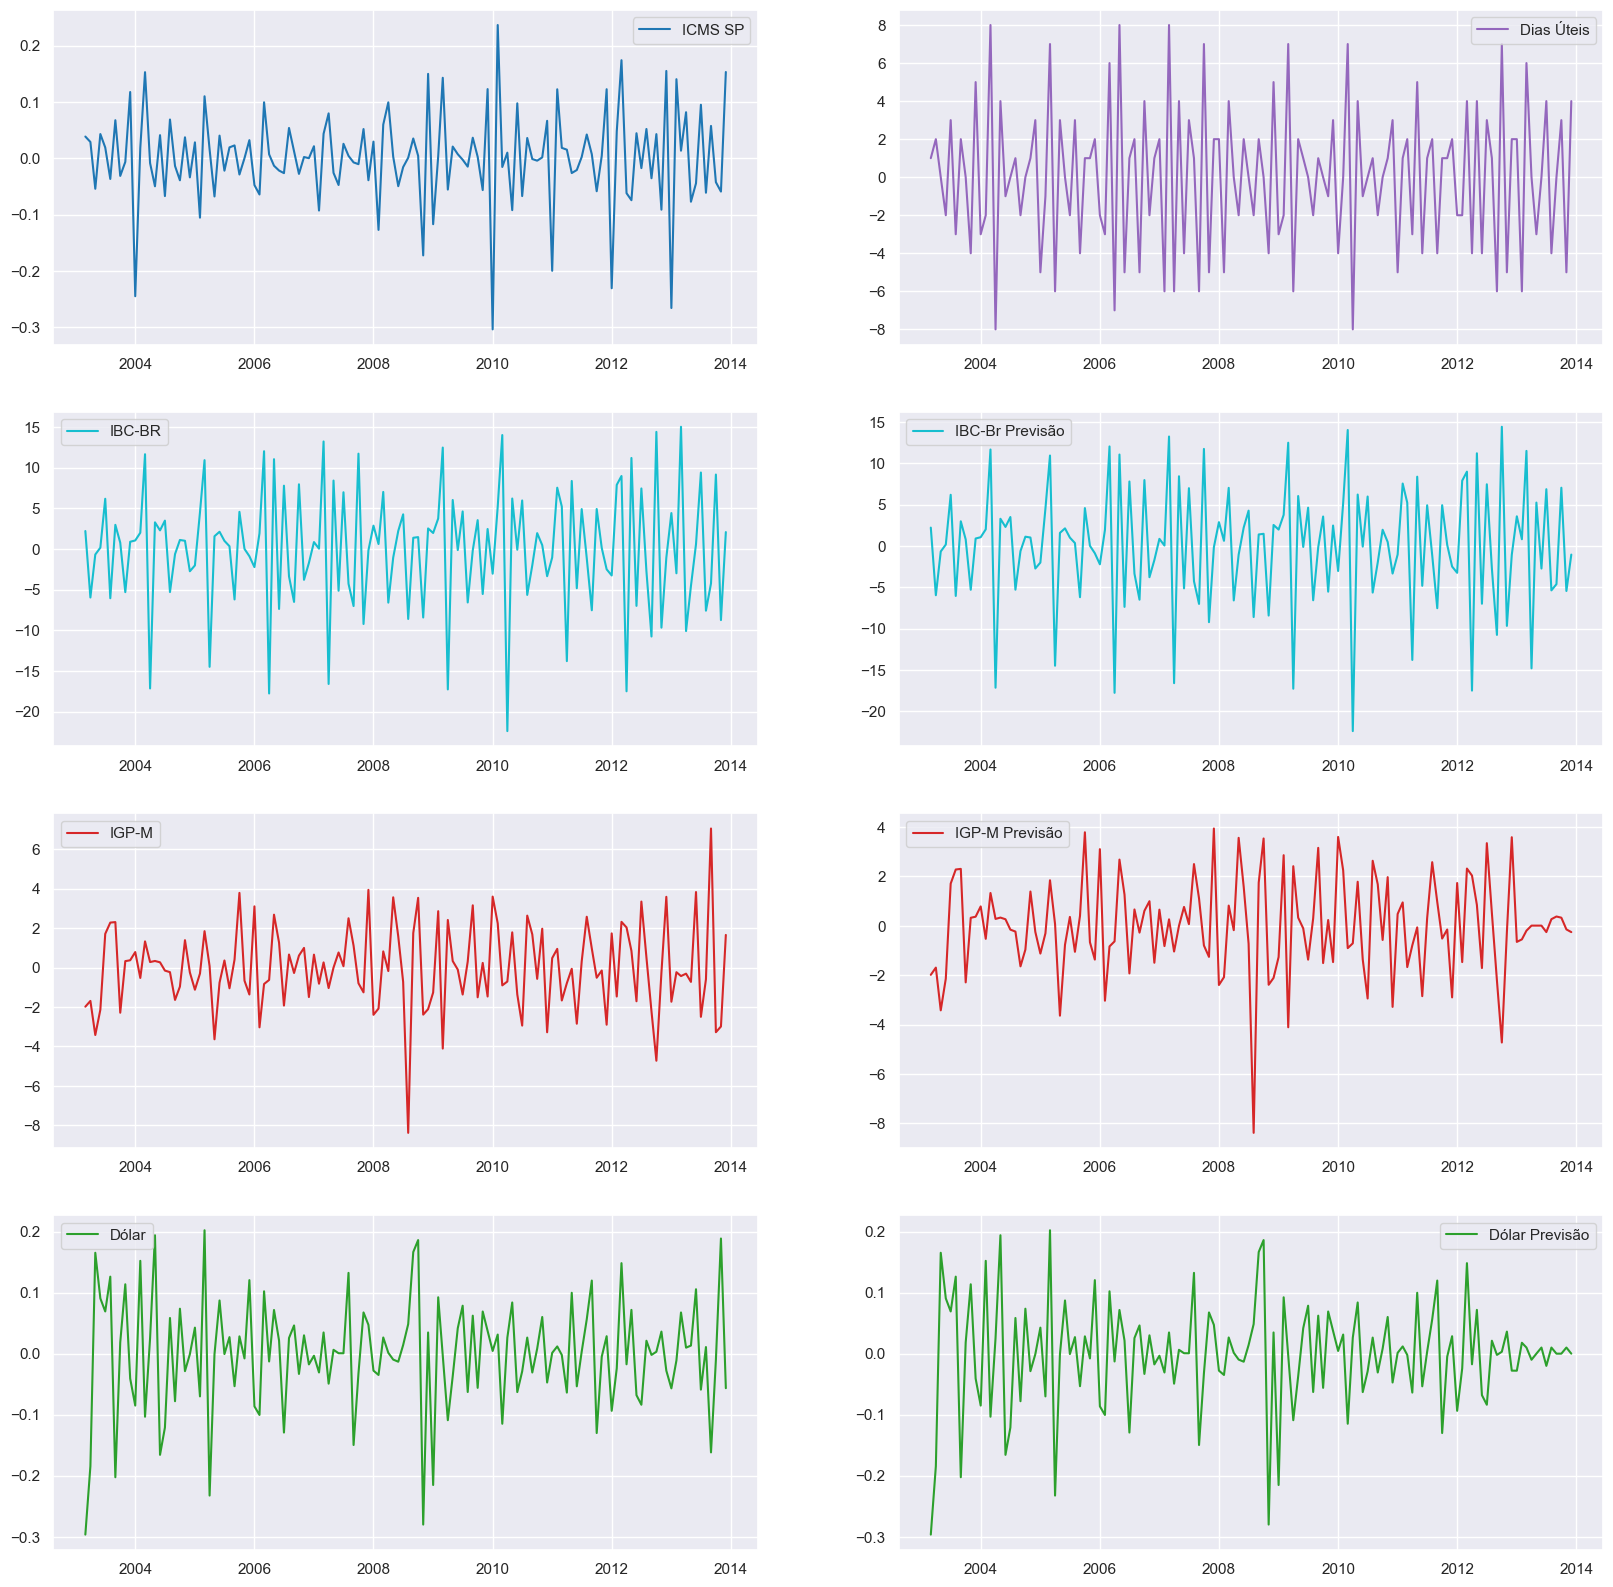

In [15]:
fig=plt.figure(figsize=(20, 20))
ax1=fig.add_subplot(421)
ax2=fig.add_subplot(422)
ax3=fig.add_subplot(423)
ax4=fig.add_subplot(424)
ax5=fig.add_subplot(425)
ax6=fig.add_subplot(426)
ax7=fig.add_subplot(427)
ax8=fig.add_subplot(428)
#plots
ax1.plot(icms_ts_d2, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts_d2, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts_d2, 'tab:cyan',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(ibcbr_prev_ts_d2, 'tab:cyan', label='IBC-Br Previsão')
ax4.legend(loc='best')
ax5.plot(igpm_ts_d2, 'tab:red', label='IGP-M')
ax5.legend(loc='best')
ax6.plot(igpm_prev_ts_d2, 'tab:red',  label='IGP-M Previsão')
ax6.legend(loc='best')
ax7.plot(dolar_ts_d2, 'tab:green', label='Dólar')
ax7.legend(loc='best')
ax8.plot(dolar_prev_ts_d2, 'tab:green', label='Dólar Previsão')
ax8.legend(loc='best')
plt.show()

### Teste de Raiz Unitária das Séries em Nível

Teste de raiz unitária Dickey-Fuller Aumentado (ADF): a hipótese nula é de que há raiz unitária e a série não é estacionária; a alternativa, de que não há e, portanto, a série é estacionária. 

Teste de raiz unitária Kwiatkowski-Phillips-Schmidt-Shin (KPSS): a hipótese nula é de que a série é de tendência estacionária; a alternativa é de há raiz unitária e a série não é estacionária.

A combinação dos dois testes pode ter os seguintes resultados com as seguintes consequências:

- Caso 1: Ambos os testes concluem que a série não é estacionária, então a série não é estacionária
- Caso 2: Ambos os testes concluem que a série é estacionária, então a série é estacionária
- Caso 3: o KPSS indica estacionariedade e o ADF indica não estacionariedade; a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência deve ser verificada quanto à estacionariedade.
- Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade; a série é estacionária diferencial. A diferenciação deve ser usada para tornar as séries estacionárias. A série diferenciada deve ser verificada quanto à estacionariedade.

**Fonte**: [Statsmodel](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [16]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

#### Série do ICMS

In [17]:
adf_test(icms_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.404256
p-value                          0.580234
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [18]:
kpss_test(icms_ts)

Results of KPSS Test:
Test Statistic           1.979668
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em nível: a 5%, não rejeita-se a nula do teste ADF e do teste KPSS. A série é estacionária de tendência e precisa ser posta em primeira diferença.

#### Série do IBC-Br

In [19]:
adf_test(ibcbr_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.137282
p-value                          0.699978
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [20]:
kpss_test(ibcbr_ts)

Results of KPSS Test:
Test Statistic           1.932773
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IBC-Br em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do IGP-M

In [21]:
adf_test(igpm_ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.945856
p-value                          0.993661
#Lags Used                       3.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [22]:
kpss_test(igpm_ts)

Results of KPSS Test:
Test Statistic           1.947667
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IGP-M em nível: a 5%, não rejeita-se a nula do teste ADF e do teste KPSS. A série é estacionária de tendência e precisa ser posta em primeira diferença.

#### Série do Dólar

In [23]:
adf_test(dolar_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -3.437597
p-value                          0.009742
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [24]:
kpss_test(dolar_ts)

Results of KPSS Test:
Test Statistic           1.274111
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do Dólar em nível: a 5%, se rejeita a nula do teste ADF e também a nula do teste KPSS. A série é estacionária diferencial e precisa ser posta em primeira diferença.

#### Série Dias Úteis

In [25]:
adf_test(dias_uteis_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -3.401319
p-value                          0.010914
#Lags Used                      11.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [26]:
kpss_test(dias_uteis_ts)

Results of KPSS Test:
Test Statistic           0.08402
p-value                  0.10000
Lags Used                8.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


Série dos Dias Úteis em nível: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em nível.

### Teste de Raiz Unitária da Série em Primeira Diferença
As séries postas em primeira diferença serão testadas para estacionariedade com os testes ADF e KPSS.

#### Série do ICMS

In [27]:
adf_test(icms_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.430483
p-value                          0.009963
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [28]:
kpss_test(icms_ts_d1)

Results of KPSS Test:
Test Statistic            0.082026
p-value                   0.100000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do ICMS em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

#### Série do IBC-Br

In [29]:
adf_test(ibcbr_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.213148
p-value                          0.019236
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [30]:
kpss_test(ibcbr_ts_d1)

Results of KPSS Test:
Test Statistic            0.100929
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do IBC-Br em primeira diferença: a 5%, se rejeita a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em primeira diferença.

#### Série do IGP-M

In [31]:
adf_test(igpm_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.275181
p-value                          0.000490
#Lags Used                       2.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [32]:
kpss_test(igpm_ts_d1)

Results of KPSS Test:
Test Statistic           0.166045
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IGP-M em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em primeira diferença.

#### Série do Dólar

In [33]:
adf_test(dolar_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                -7.956842e+00
p-value                        3.021347e-12
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


In [34]:
kpss_test(dolar_ts_d1)

Results of KPSS Test:
Test Statistic           0.462397
p-value                  0.050260
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do Dólar em primeira diferença: a 5%, rejeita-se a nula do teste ADF e também se rejeita a nula do teste KPSS. A série é estacionária pelo teste ADF mas não é estacionária pelo teste KPSS. A série precisa ser diferenciada novamente para poder ser usada.

##### Diferenciando novamente a série e testando a estacionariedade

In [35]:
dolar_ts_d2 = dolar_ts_d1.diff().dropna()

In [36]:
adf_test(dolar_ts_d2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.529465
p-value                          0.000002
#Lags Used                      12.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [37]:
kpss_test(dolar_ts_d2)

Results of KPSS Test:
Test Statistic            0.179427
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do Dólar em segunda diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em segunda diferença.

#### Série Dias Úteis

Não será testada, pois já é estacionária em nível.

### Estacionariedade das Séries

Conclue-se que, para se trabalhar com todas as séries estacionárias, as séries serão usadas em nível, em primeira ou segunda diferença, conforme abaixo:
- ICMS: primeira diferença
- IBC-Br: primeira diferença
- IGP-M: primeira diferença
- Dólar: segunda diferença
- Dias Úteis: nível

##### Equalizando o tamanho das séries
IPCA e Dias Úteis ficaram maiores que as demais séries estão em nível, assim como as séries em primeira diferenças estão maiores do que as em segunda diferença. O primeiro e o segundo valores destas duas séries, e somente o primeiro das que estão em primeira diferança serão removidos.

In [38]:
print('antes', icms_ts_d1.shape, ibcbr_ts_d1.shape, igpm_ts_d1.shape, dolar_ts_d2.shape, dias_uteis_ts.shape,
     ibcbr_prev_ts_d1.shape, igpm_prev_ts_d2.shape, dolar_prev_ts_d2.shape,)
icms_ts_adj = icms_ts_d1[1:]
ibcbr_ts_adj = ibcbr_ts_d1[1:]
igpm_ts_adj = igpm_ts_d1[1:]
dolar_ts_adj = dolar_ts_d2
dias_uteis_ts_adj = dias_uteis_ts[2:]
ibcbr_prev_ts_adj = ibcbr_prev_ts_d1[1:]
igpm_prev_ts_adj = igpm_prev_ts_d2
dolar_prev_ts_adj = dolar_prev_ts_d2
print('depois', icms_ts_adj.shape, ibcbr_ts_adj.shape, igpm_ts_adj.shape, dolar_ts_adj.shape, 
      dias_uteis_ts_adj.shape, ibcbr_prev_ts_adj.shape, igpm_prev_ts_adj.shape, dolar_prev_ts_adj.shape)

antes (131,) (131,) (131,) (130,) (132,) (131,) (130,) (130,)
depois (130,) (130,) (130,) (130,) (130,) (130,) (130,) (130,)


### Dessazonalização das Séries

In [39]:
sns.set(rc={'figure.figsize':(15,8)})

#### Série do ICMS

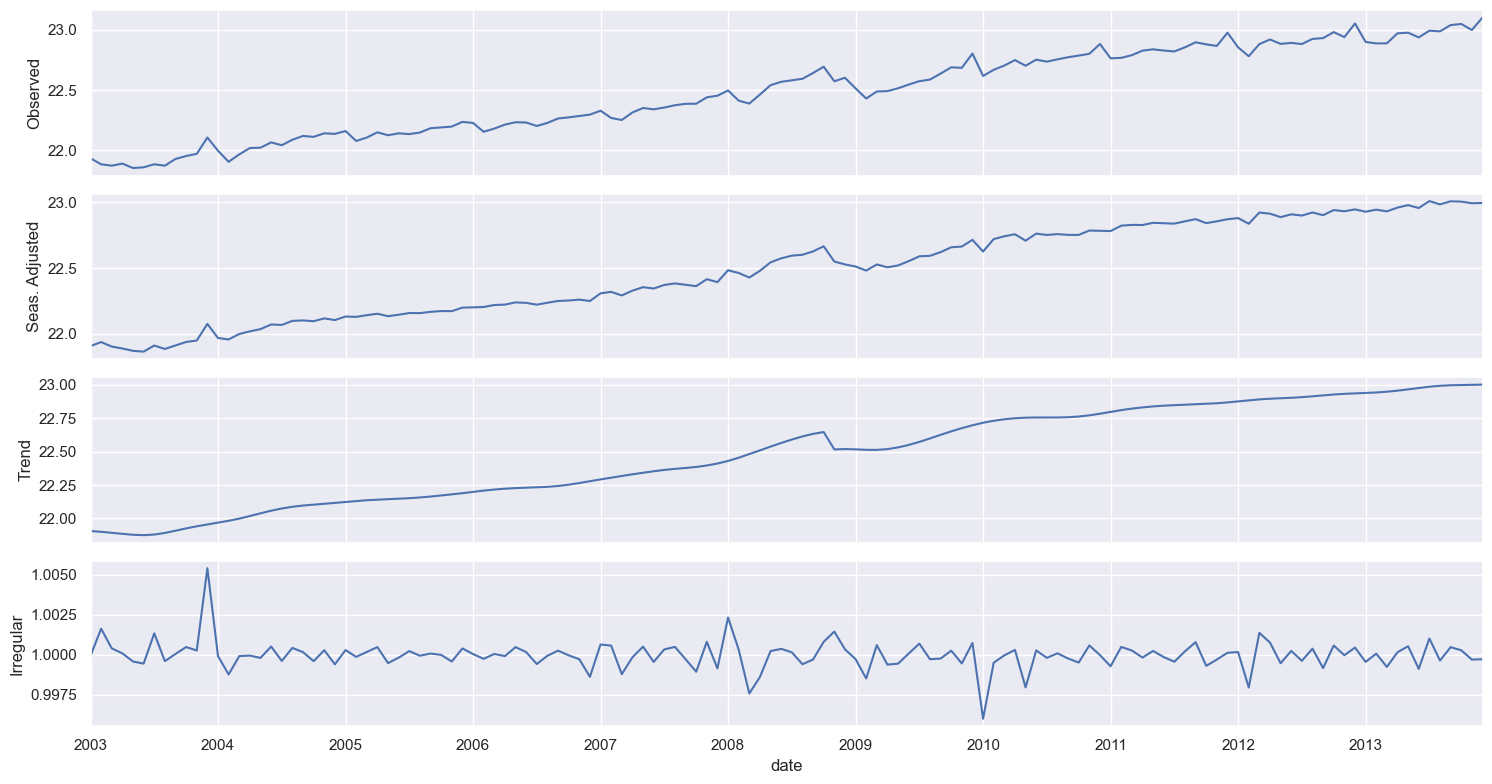

In [40]:
seas_icms = statsmodels.tsa.x13.x13_arima_analysis(icms_ts, x12path='./x13asmac/')
plot = seas_icms.plot()

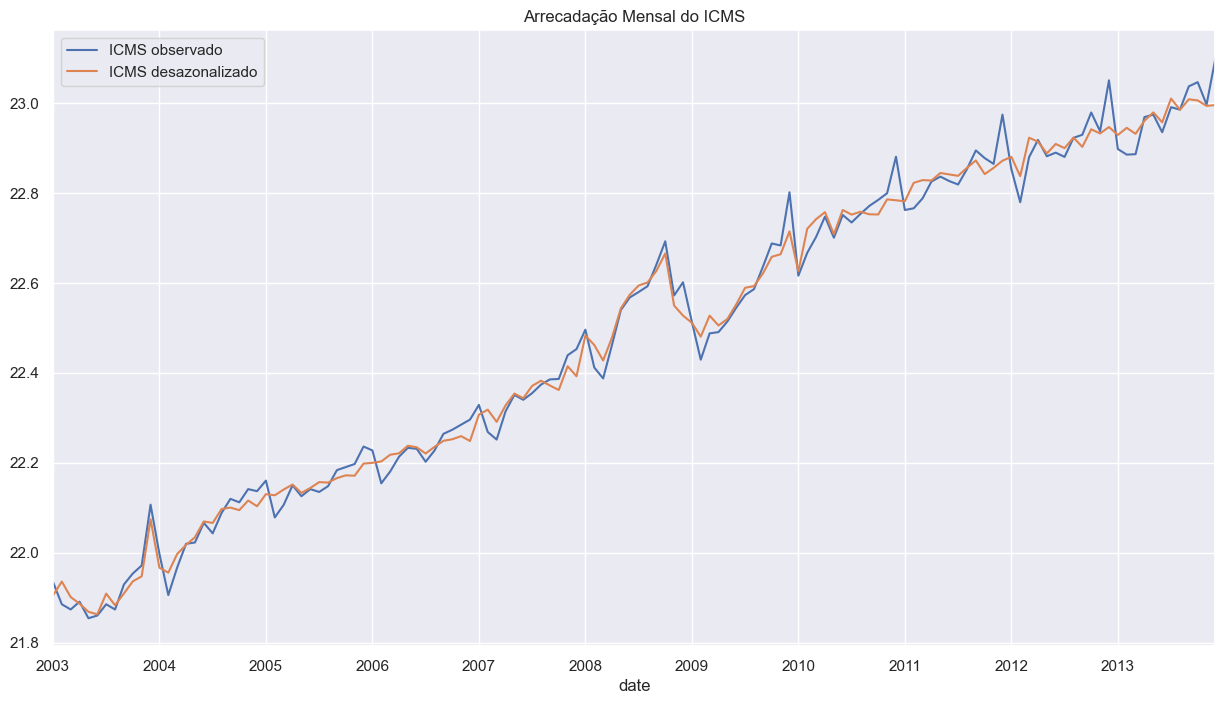

In [41]:
icms_decomp = pd.DataFrame(data={'ICMS observado': seas_icms.observed, 
                                 'ICMS desazonalizado': seas_icms.seasadj})
plot = icms_decomp.plot(title='Arrecadação Mensal do ICMS')

#### Série do IBC-Br

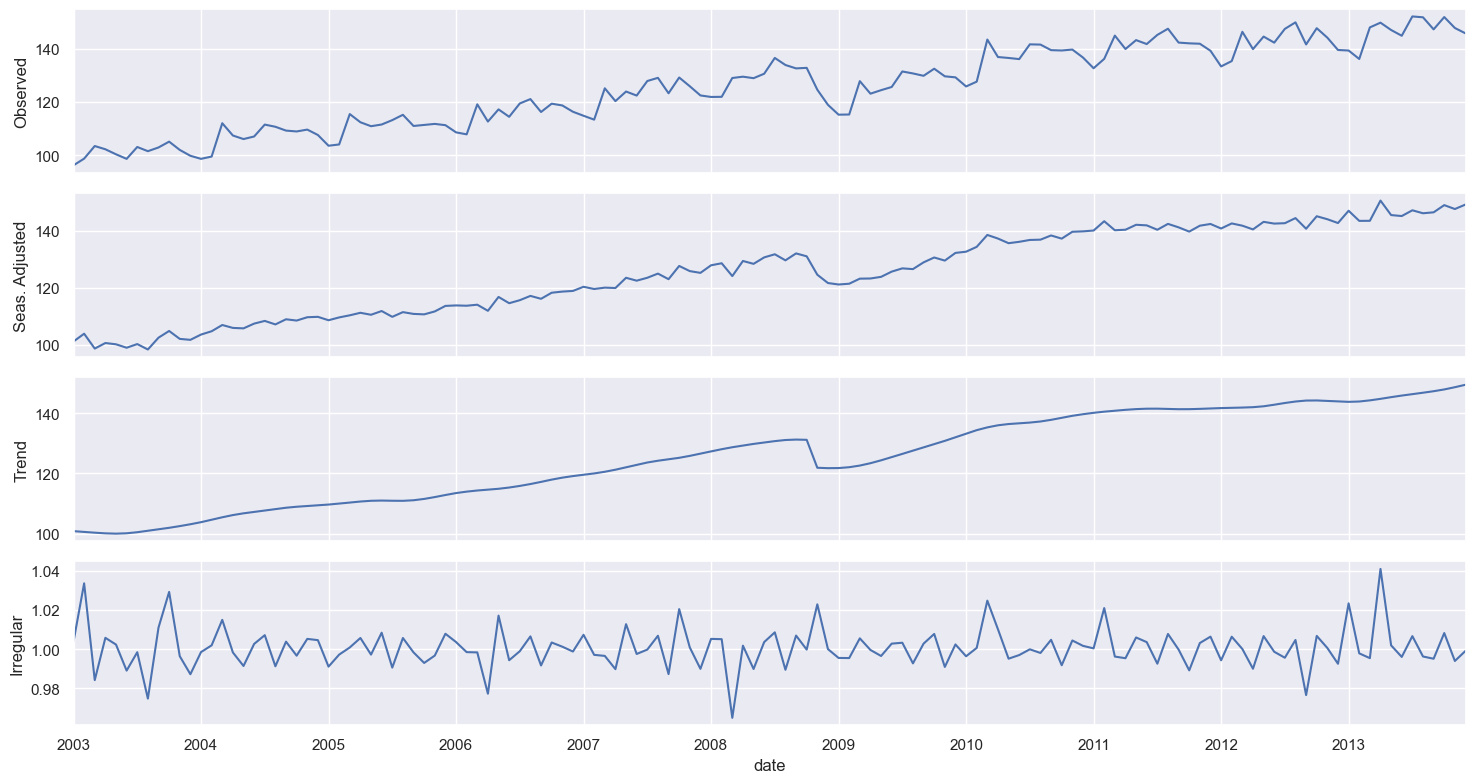

In [42]:
sns.set(rc={'figure.figsize':(15,8)})
seas_ibcbr = statsmodels.tsa.x13.x13_arima_analysis(ibcbr_ts, x12path='./x13asmac/')
plot = seas_ibcbr.plot()

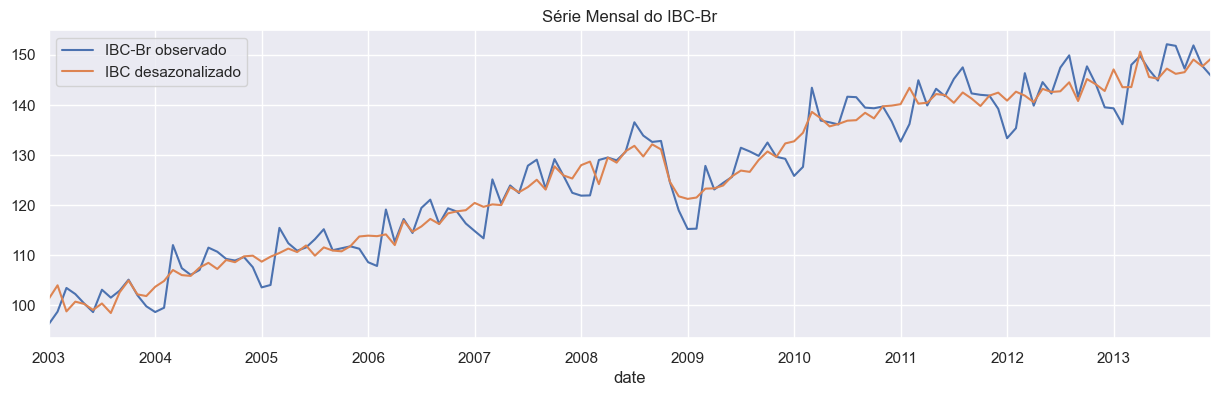

In [43]:
sns.set(rc={'figure.figsize':(15,4)})
ibcbr_decomp = pd.DataFrame(data={'IBC-Br observado': seas_ibcbr.observed, 
                                  'IBC desazonalizado': seas_ibcbr.seasadj})
plot = ibcbr_decomp.plot(title='Série Mensal do IBC-Br')

#### Série do IGP-DI

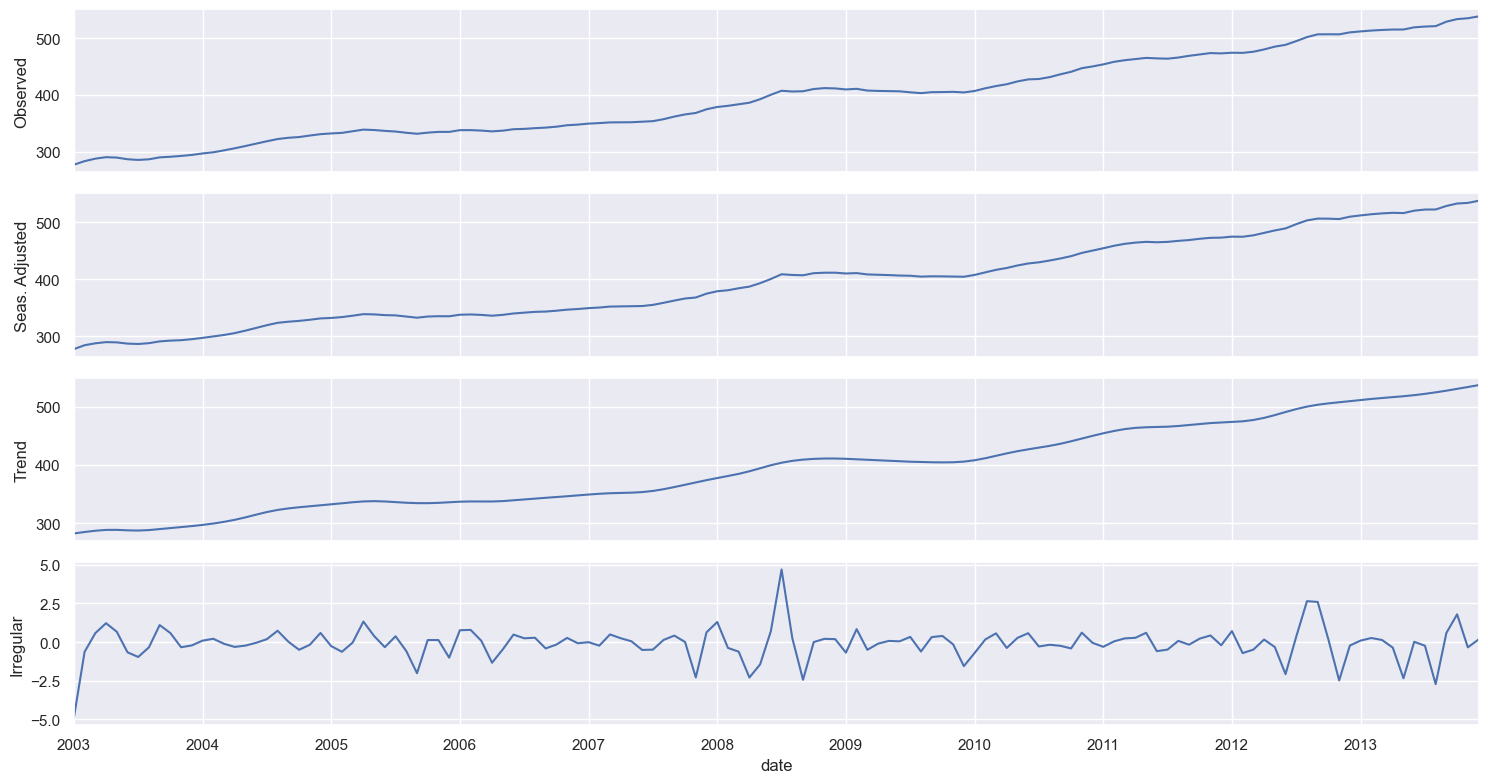

In [44]:
sns.set(rc={'figure.figsize':(15,8)})
seas_igpm = statsmodels.tsa.x13.x13_arima_analysis(igpm_ts, x12path='./x13asmac/')
plot = seas_igpm.plot()

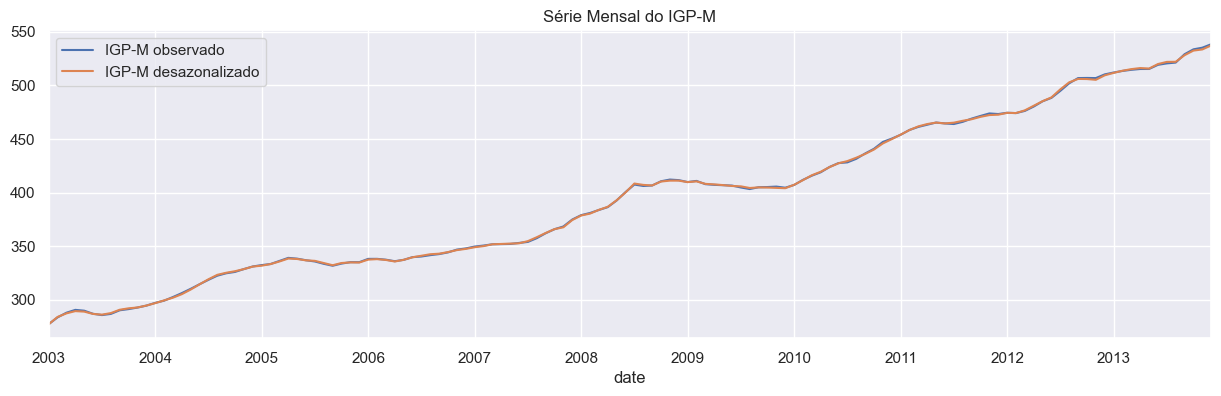

In [45]:
sns.set(rc={'figure.figsize':(15,4)})
igpm_decomp = pd.DataFrame(data={'IGP-M observado': seas_igpm.observed, 
                                  'IGP-M desazonalizado': seas_igpm.seasadj})
plot = igpm_decomp.plot(title='Série Mensal do IGP-M')

#### Série do Dólar

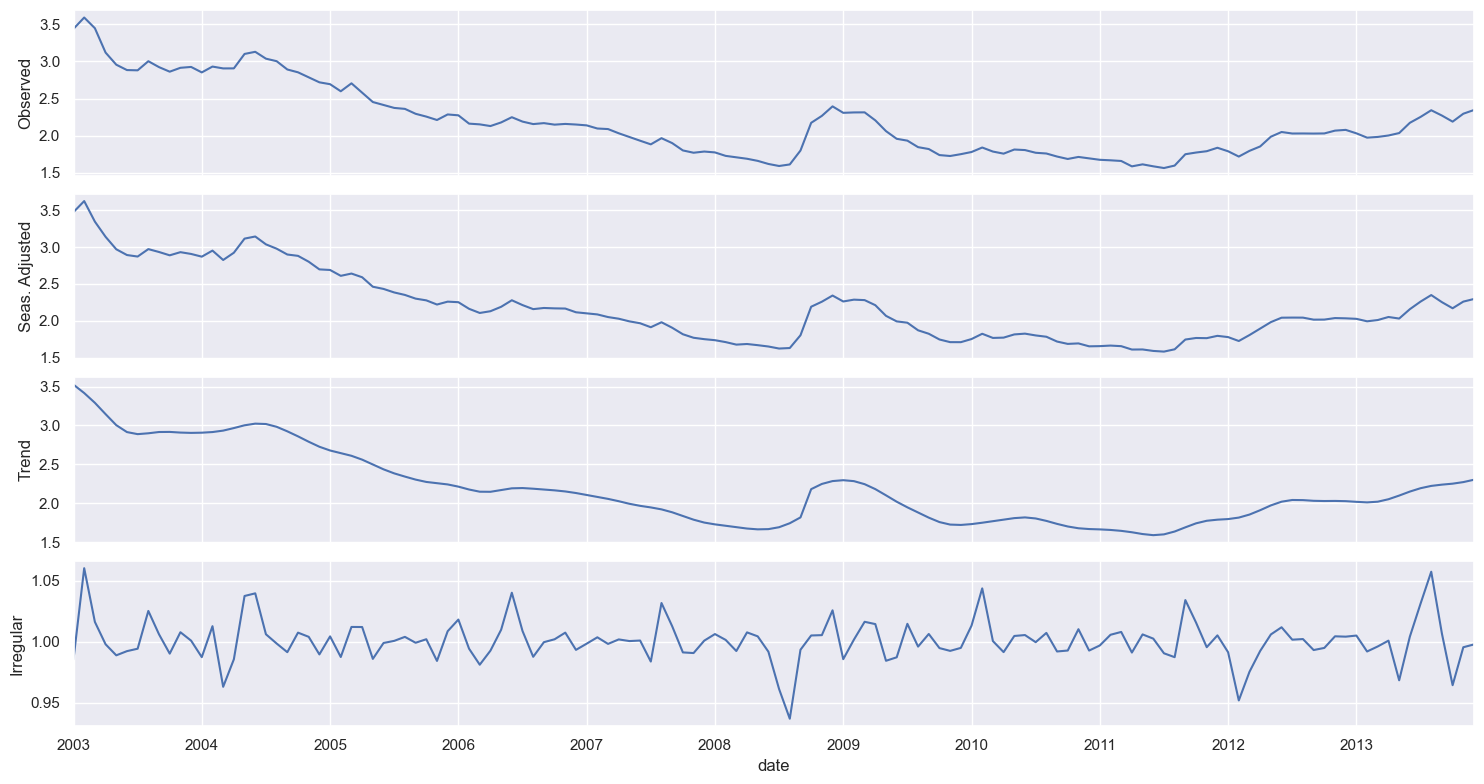

In [46]:
sns.set(rc={'figure.figsize':(15,8)})
seas_dolar = statsmodels.tsa.x13.x13_arima_analysis(dolar_ts, x12path='./x13asmac/')
plot = seas_dolar.plot()

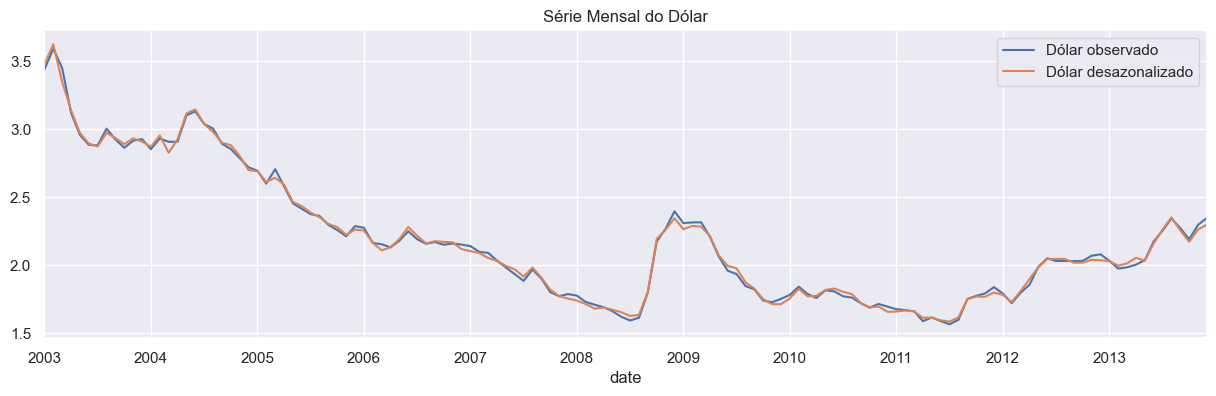

In [47]:
sns.set(rc={'figure.figsize':(15,4)})
dolar_decomp = pd.DataFrame(data={'Dólar observado': seas_dolar.observed, 
                                  'Dólar desazonalizado': seas_dolar.seasadj})
plot = dolar_decomp.plot(title='Série Mensal do Dólar')

#### Série dos Dias Úteis

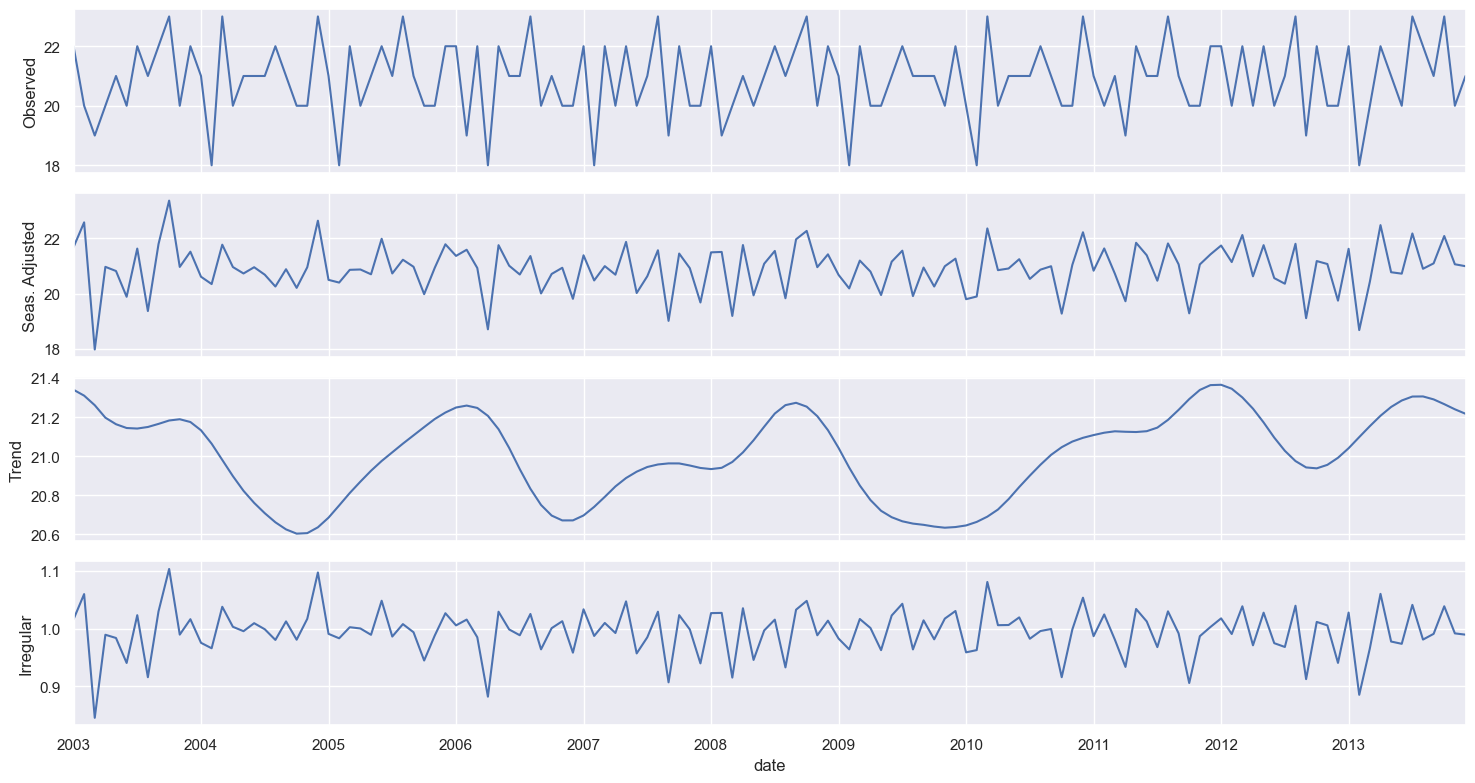

In [48]:
sns.set(rc={'figure.figsize':(15,8)})
seas_dias_uteis = statsmodels.tsa.x13.x13_arima_analysis(dias_uteis_ts, x12path='./x13asmac/')
plot = seas_dias_uteis.plot()

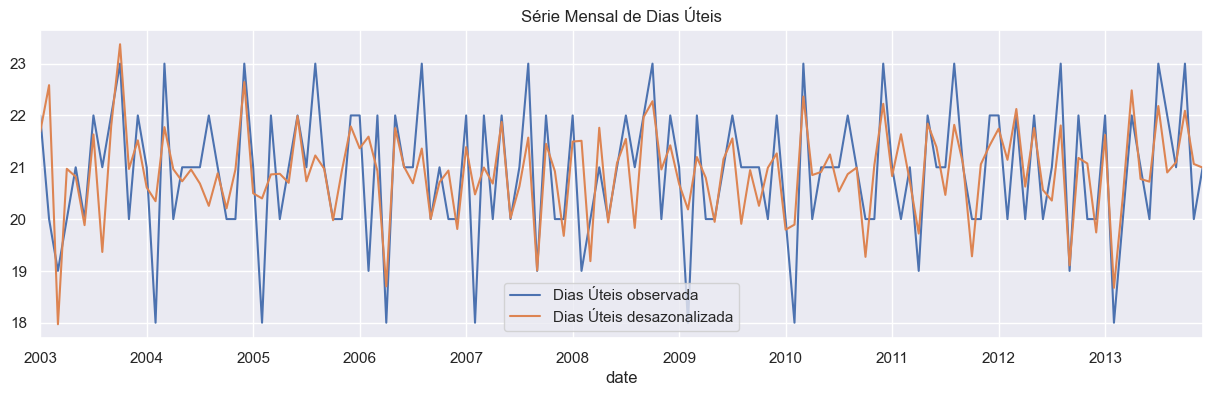

In [49]:
sns.set(rc={'figure.figsize':(15,4)})
dias_uteis_decomp = pd.DataFrame(data={'Dias Úteis observada': seas_dias_uteis.observed, 
                                  'Dias Úteis desazonalizada': seas_dias_uteis.seasadj})
plot = dias_uteis_decomp.plot(title='Série Mensal de Dias Úteis')

In [50]:
sns.set(rc={'figure.figsize':(15,8)})

### Criando dummies de intervenção

In [51]:
pos = seas_icms.results.find('Outliers')
print(seas_icms.results[pos-309:pos+2105])

 ------------------------------------------------------------------------------
                             Parameter        Standard
 Variable                     Estimate           Error      t-value
 ------------------------------------------------------------------------------
 Automatically Identified Outliers
   AO2003.Dec                   0.0055         0.00117         4.73
   LS2008.Nov                  -0.0061         0.00113        -5.43
   AO2010.Jan                  -0.0042         0.00101        -4.10
 ------------------------------------------------------------------------------


 ARIMA Model:  (0 1 1)(0 1 1)
   Nonseasonal differences: 1
   Seasonal differences:    1
                                              Standard
 Parameter                    Estimate          Errors
 -----------------------------------------------------
 Nonseasonal MA                                    
   Lag  1                       0.3755         0.08474

 Seasonal MA                     

In [52]:
ao2003dez = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
dt_final = str(ao2003dez.index[-1])

ao2003dez['2003-12-01'] = 1

ls2008nov = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2008nov['2008-11-01':dt_final] = 1
ao2010jan = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))

ao2010jan['2010-01-01'] = 1

In [53]:
ao2003dez.shape, ls2008nov.shape, ao2010jan.shape

((132,), (132,), (132,))

### Testes de Causalidade de Granger
Verificando quais das séries causam ICMS para que possam ser usadas como exógenas nos modelos.

#### Verificando se IBC-Br granger causa ICMS

In [54]:
gt_data = pd.DataFrame({'ibcbr':list(seas_ibcbr.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.3190 , p=0.0006  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=12.6077 , p=0.0004  , df=1
likelihood ratio test: chi2=12.0373 , p=0.0005  , df=1
parameter F test:         F=12.3190 , p=0.0006  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3880  , p=0.2534  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=2.8870  , p=0.2361  , df=2
likelihood ratio test: chi2=2.8554  , p=0.2399  , df=2
parameter F test:         F=1.3880  , p=0.2534  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3287  , p=0.8046  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=1.0427  , p=0.7909  , df=3
likelihood ratio test: chi2=1.0385  , p=0.7919  , df=3
parameter F test:         F=0.3287  , p=0.8046  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9725  , p=0.4253  

{1: ({'ssr_ftest': (12.318991645649154, 0.0006195928129125545, 128.0, 1),
   'ssr_chi2test': (12.607718012344057, 0.0003841572178263425, 1),
   'lrtest': (12.037338293029165, 0.000521453791949828, 1),
   'params_ftest': (12.318991645649746, 0.0006195928129123736, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.3880000460155126, 0.25339337809137036, 125.0, 2),
   'ssr_chi2test': (2.887040095712266, 0.23609522776708478, 2),
   'lrtest': (2.855449258839144, 0.23985405868357557, 2),
   'params_ftest': (1.3880000460152881, 0.25339337809142876, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.3287044639167593, 0.804601207968557, 122.0, 3),
   'ssr_chi2test': (1.0426936683261134, 0.7909228753538609, 3),
   'lrtest': (1.0385022464831764, 0.7919366695500363, 3),
   'params_ftest': (0.3287044639166784, 0.8046012079686168, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

A 5%, IBC-Br granger causa ICMS no lag 7.

#### Verificando se IGP-M granger causa ICMS

In [55]:
gt_data = pd.DataFrame({'igpm':list(seas_igpm.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1301  , p=0.0252  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=5.2503  , p=0.0219  , df=1
likelihood ratio test: chi2=5.1479  , p=0.0233  , df=1
parameter F test:         F=5.1301  , p=0.0252  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3338  , p=0.1011  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=4.8543  , p=0.0883  , df=2
likelihood ratio test: chi2=4.7659  , p=0.0923  , df=2
parameter F test:         F=2.3338  , p=0.1011  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3674  , p=0.0741  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=7.5098  , p=0.0573  , df=3
likelihood ratio test: chi2=7.2994  , p=0.0629  , df=3
parameter F test:         F=2.3674  , p=0.0741  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2247  , p=0.0704  

{1: ({'ssr_ftest': (5.130101203673604, 0.025195220440565137, 128.0, 1),
   'ssr_chi2test': (5.250337950634703, 0.02194250896851174, 1),
   'lrtest': (5.147853383109123, 0.02327512925450072, 1),
   'params_ftest': (5.130101203673818, 0.02519522044056181, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.3337940902074514, 0.10113727507649577, 125.0, 2),
   'ssr_chi2test': (4.854291707631499, 0.08828846149419305, 2),
   'lrtest': (4.76585517363992, 0.09228002388729233, 2),
   'params_ftest': (2.3337940902079883, 0.10113727507644314, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.367436634020645, 0.07411908651739169, 122.0, 3),
   'ssr_chi2test': (7.509819486606473, 0.05730668343775879, 3),
   'lrtest': (7.29935474457352, 0.06294431605682195, 3),
   'params_ftest': (2.3674366340210775, 0.07411908651735023, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

A 5%, IGP-DI granger causa ICMS a partir do lag 6.

#### Verificando se Dólar granger causa ICMS

In [56]:
gt_data = pd.DataFrame({'dolar':list(seas_dolar.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4123  , p=0.2369  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=1.4454  , p=0.2293  , df=1
likelihood ratio test: chi2=1.4375  , p=0.2305  , df=1
parameter F test:         F=1.4123  , p=0.2369  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4246  , p=0.6550  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=0.8831  , p=0.6430  , df=2
likelihood ratio test: chi2=0.8802  , p=0.6440  , df=2
parameter F test:         F=0.4246  , p=0.6550  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3609  , p=0.2580  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=4.3170  , p=0.2292  , df=3
likelihood ratio test: chi2=4.2463  , p=0.2361  , df=3
parameter F test:         F=1.3609  , p=0.2580  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7850  , p=0.1363  

{1: ({'ssr_ftest': (1.412334511662752, 0.23686951552204205, 128.0, 1),
   'ssr_chi2test': (1.4454361017798478, 0.2292616827181429, 1),
   'lrtest': (1.4375199071267843, 0.23054109535246942, 1),
   'params_ftest': (1.4123345116626467, 0.23686951552206087, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.4245898952470982, 0.6549776400643887, 125.0, 2),
   'ssr_chi2test': (0.8831469821139645, 0.6430238323927409, 2),
   'lrtest': (0.8801606969705063, 0.6439846758111145, 2),
   'params_ftest': (0.4245898952470657, 0.6549776400644071, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.3609053524495212, 0.25800307773505443, 122.0, 3),
   'ssr_chi2test': (4.316970257360366, 0.2292087551198289, 3),
   'lrtest': (4.2463089285730575, 0.23606618696424178, 3),
   'params_ftest': (1.3609053524492551, 0.2580030777351345, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

A 5%, Dólar granger causa ICMS no a partir do lag 1.

#### Verificando se Dias Úteis granger causa ICMS

In [57]:
gt_data = pd.DataFrame({'dias_uteis':list(seas_dias_uteis.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2157  , p=0.6431  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=0.2208  , p=0.6384  , df=1
likelihood ratio test: chi2=0.2206  , p=0.6386  , df=1
parameter F test:         F=0.2157  , p=0.6431  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4241  , p=0.6553  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=0.8822  , p=0.6433  , df=2
likelihood ratio test: chi2=0.8792  , p=0.6443  , df=2
parameter F test:         F=0.4241  , p=0.6553  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2574  , p=0.8559  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=0.8165  , p=0.8455  , df=3
likelihood ratio test: chi2=0.8140  , p=0.8461  , df=3
parameter F test:         F=0.2574  , p=0.8559  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4607  , p=0.7645  

{1: ({'ssr_ftest': (0.21573474390741146, 0.6430982868242845, 128.0, 1),
   'ssr_chi2test': (0.22079102696774142, 0.6384378554155643, 1),
   'lrtest': (0.22060517211349406, 0.6385791939896655, 1),
   'params_ftest': (0.2157347439073432, 0.6430982868243285, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.4241123073724417, 0.6552884136148522, 125.0, 2),
   'ssr_chi2test': (0.8821535993346787, 0.6433432961245001, 2),
   'lrtest': (0.8791740133954704, 0.6443024587435677, 2),
   'params_ftest': (0.42411230737239924, 0.6552884136148798, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.2574062497939473, 0.8559308383931904, 122.0, 3),
   'ssr_chi2test': (0.816526382543095, 0.8455101939084834, 3),
   'lrtest': (0.8139530676844515, 0.8461268151975343, 3),
   'params_ftest': (0.25740624979396715, 0.8559308383931709, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

A 5%, Dias Úteis granger causa ICMS no lag 10.

#### Resumos dos testes de causalidade

- IBC-Br: granger causa no lag 7.
- IGP-DI: granger causa a partir do lag 6.
- Dólar: granger causa a partir do lag 1.
- Dias Úteis: granger causa a partir do lag 10.

## Preparação para Previsões

O artigo usa, além de MAPE e MSE, o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [58]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões

In [59]:
previsoes = {
    'nome':[],
    'modelo': [],
    'aic':[],
    'bic':[],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos SARIMAX com variáveis exógenas
As previsões do IBC-Br, IGP-M e Dólar foram obtidas no Sistema de Expectativas de Mercado do Bacen em 27/12/2021. Cada uma das previsões com as variáveis previstas será comparada com as variáveis reais.

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Serão usadas as séries com sazonalidade e em nível e as questões de sazonalidade e estacionariedade serão tratadas pelo modelo.

In [60]:
exog_df = pd.DataFrame((ibcbr_prev_ts, igpm_prev_ts,
                        dolar_prev_ts, dias_uteis_ts, ao2003dez, ls2008nov, ao2010jan
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis',
                               'ao2003dez','ls2008nov', 'ao2010jan'
                            ]).transpose()
exog_df.head() 

ibcbr    igpdi   dolar  dias_uteis  ao2003dez  ls2008nov  \
2003-01-01   96.15  277.173  3.4384        22.0        0.0        0.0   
2003-02-01   98.67  283.506  3.5908        20.0        0.0        0.0   
2003-03-01  103.41  287.855  3.4469        19.0        0.0        0.0   
2003-04-01  102.19  290.512  3.1187        20.0        0.0        0.0   
2003-05-01  100.30  289.747  2.9557        21.0        0.0        0.0   

            ao2010jan  
2003-01-01        0.0  
2003-02-01        0.0  
2003-03-01        0.0  
2003-04-01        0.0  
2003-05-01        0.0

In [61]:
exog_df.tail() 

ibcbr       igpdi  dolar  dias_uteis  ao2003dez  ls2008nov  \
2013-08-01  152.985410  527.544908   2.07        22.0        0.0        1.0   
2013-09-01  148.834167  530.024369   2.07        21.0        0.0        1.0   
2013-10-01  151.727873  532.833498   2.07        23.0        0.0        1.0   
2013-11-01  149.174166  535.497666   2.08        20.0        0.0        1.0   
2013-12-01  145.576261  537.907405   2.09        21.0        0.0        1.0   

            ao2010jan  
2013-08-01        0.0  
2013-09-01        0.0  
2013-10-01        0.0  
2013-11-01        0.0  
2013-12-01        0.0

In [62]:
exog = exog_df[:].to_numpy()
exog_train = exog[:-12]
exog_test = exog[-12:]
print(exog.shape, exog_train.shape, exog_test.shape)

(132, 7) (120, 7) (12, 7)


In [63]:
icms_train = icms_ts[:-12]
icms_test = np.exp(icms_ts[-12:]) # série sem log
print(icms_ts.shape, icms_train.shape, icms_test.shape)

(132,) (120,) (12,)


In [64]:
exog_reais_df = pd.DataFrame((ibcbr_ts, igpm_ts,
                        dolar_ts, dias_uteis_ts, ao2003dez, ls2008nov, ao2010jan
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis',
                               'ao2003dez', 'ls2008nov', 'ao2010jan'
                            ]).transpose()
exog_reais_df.head() 

ibcbr    igpdi   dolar  dias_uteis  ao2003dez  ls2008nov  \
2003-01-01   96.15  277.173  3.4384        22.0        0.0        0.0   
2003-02-01   98.67  283.506  3.5908        20.0        0.0        0.0   
2003-03-01  103.41  287.855  3.4469        19.0        0.0        0.0   
2003-04-01  102.19  290.512  3.1187        20.0        0.0        0.0   
2003-05-01  100.30  289.747  2.9557        21.0        0.0        0.0   

            ao2010jan  
2003-01-01        0.0  
2003-02-01        0.0  
2003-03-01        0.0  
2003-04-01        0.0  
2003-05-01        0.0

In [65]:
exog_reais_df.tail() 

ibcbr    igpdi     dolar  dias_uteis  ao2003dez  ls2008nov  \
2013-08-01  151.81  521.270  2.342191        22.0        0.0        1.0   
2013-09-01  147.27  529.085  2.270510        21.0        0.0        1.0   
2013-10-01  151.90  533.621  2.188648        23.0        0.0        1.0   
2013-11-01  147.79  535.168  2.295350        20.0        0.0        1.0   
2013-12-01  145.77  538.370  2.345486        21.0        0.0        1.0   

            ao2010jan  
2013-08-01        0.0  
2013-09-01        0.0  
2013-10-01        0.0  
2013-11-01        0.0  
2013-12-01        0.0

In [66]:
exog_reais = exog_reais_df[:].to_numpy()
exog_reais_test = exog_reais[-12:]
print(exog_reais.shape, exog_reais_test.shape)

(132, 7) (12, 7)


### Auto Arima da Série

#### Critério de Akaike

In [67]:
mod_aa_aic = auto_arima(y=icms_train, x=exog_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', stepewise=True,
                        trace=10)
mod_aa_aic

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-410.848, Time=0.60 sec
First viable model found (-410.848)
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-367.165, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-408.701, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-398.448, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-365.192, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-398.837, Time=0.48 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-405.353, Time=0.50 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-408.612, Time=1.30 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-409.774, Time=1.14 sec
Near non-invertible roots for order (2, 1, 2)(0, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-397.096, Time=1.07 sec
 ARIMA(2,1,2)(2,0,0)[12] inter

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [68]:
mod_aa_bic = auto_arima(y=icms_train, x=exog_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='bic', stepewise=True,
                        trace=10)
mod_aa_bic

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=-388.615, Time=0.60 sec
First viable model found (-388.615)
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-361.606, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-397.585, Time=0.17 sec
New best model found (-397.585 < -388.615)
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-387.332, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-362.413, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=-363.538, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=-396.613, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=-399.831, Time=0.37 sec
New best model found (-399.831 < -397.585)
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=-384.107, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=-396.630, Time=0.84 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : BIC=-396.695, Time=0.90 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : BIC=-385.869, Time=0.47 sec
 ARIMA(1,1,0)(2,0,2)[12] interc

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMAX(0,1,1),(1,0,1) sugerido pelo critério de Akaike e de Schwarz

In [69]:
mod_arima2 = ARIMA(endog=icms_train, exog=exog_train, order=(0, 1, 1), seasonal_order=(1, 0, 1, 12))
res_arima2 = mod_arima2.fit()
print(res_arima2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  120
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 252.508
Date:                          Mon, 21 Aug 2023   AIC                           -483.016
Time:                                  16:09:12   BIC                           -452.445
Sample:                              01-01-2003   HQIC                          -470.602
                                   - 12-01-2012                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0035      0.002      2.065      0.039       0.000       0.007
x2             0.0008      0.001      1.348      0.

In [70]:
previsoes['aic'].append(res_arima2.aic)
previsoes['bic'].append(res_arima2.bic)

#### Análise dos Resíduos

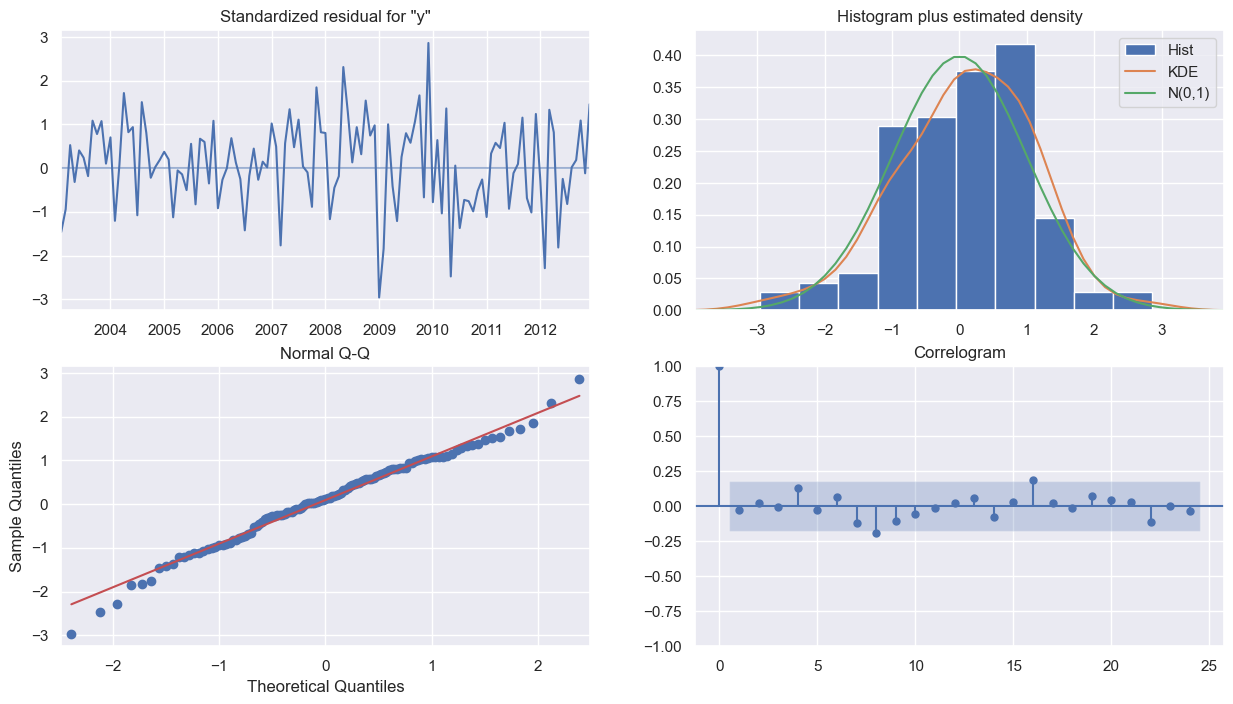

In [71]:
ax = res_arima2.plot_diagnostics(lags=24)

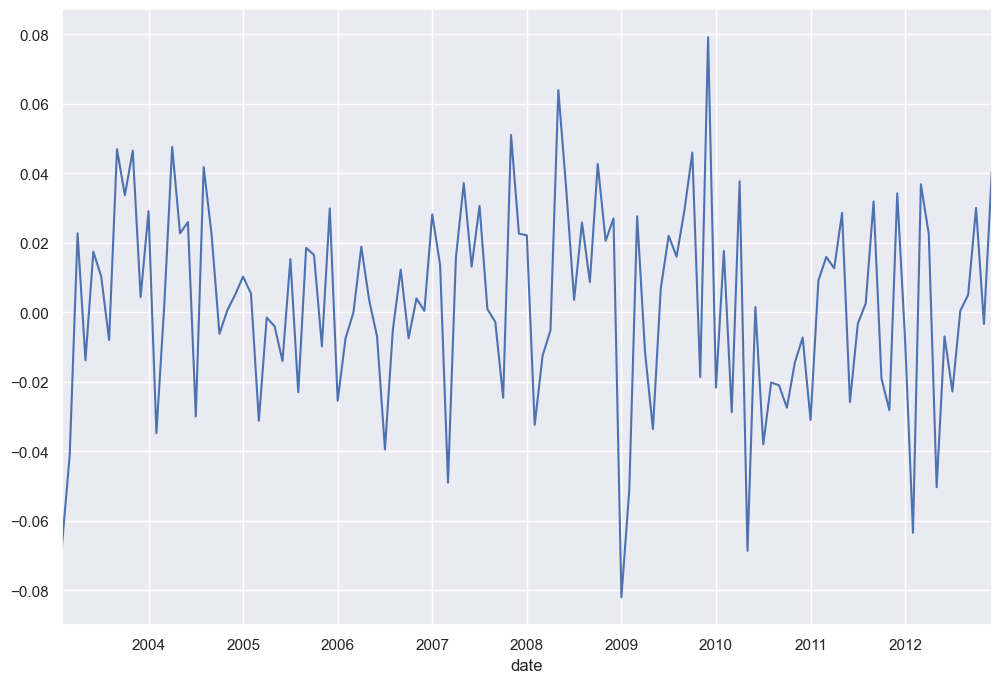

In [72]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima2.resid[1:].plot(ax=ax)

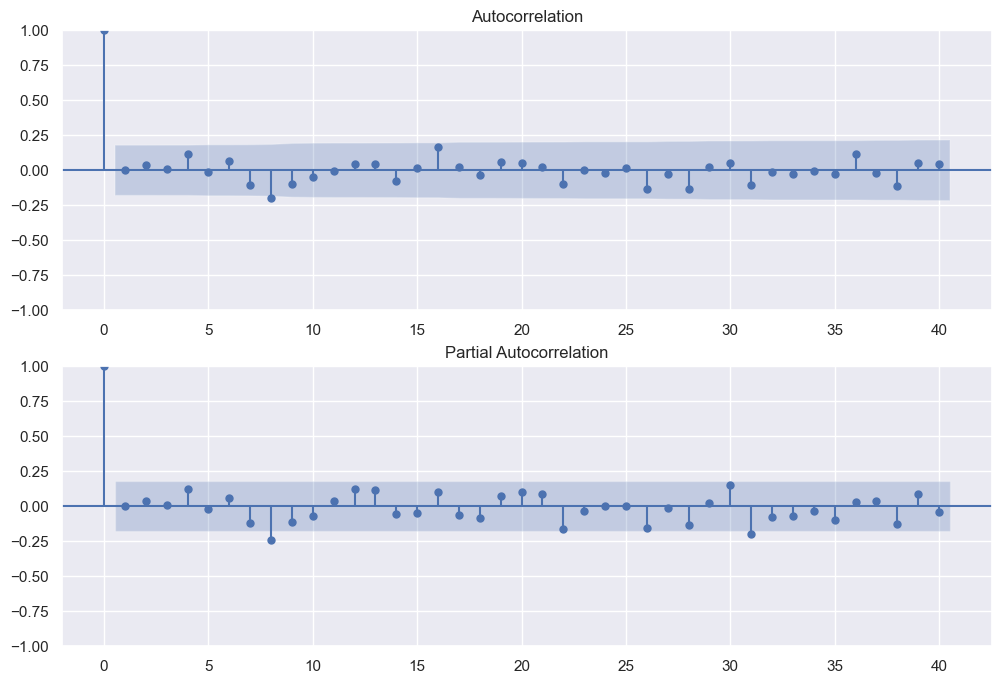

In [73]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima2.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima2.resid[1:], lags=40, ax=ax2)

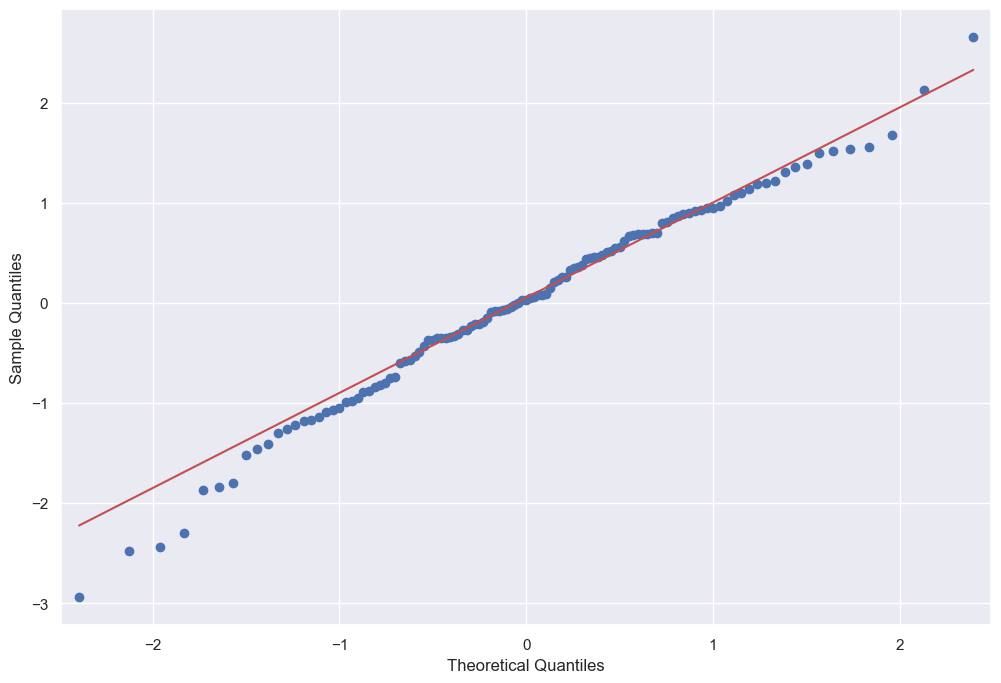

In [74]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima2.resid[1:], line="q", ax=ax, fit=True)

#### Previsões com Exógenas Previstas

In [75]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima2)

In [76]:
y_arima2_pred = np.exp(res_arima2.forecast(12, exog=exog_test))
previsoes['previsoes'].append(y_arima2_pred)
y_arima2_pred

2013-01-01    9.386985e+09
2013-02-01    8.819138e+09
2013-03-01    9.572178e+09
2013-04-01    1.000040e+10
2013-05-01    9.528873e+09
2013-06-01    9.597817e+09
2013-07-01    9.645359e+09
2013-08-01    9.804562e+09
2013-09-01    1.000559e+10
2013-10-01    1.032016e+10
2013-11-01    9.967158e+09
2013-12-01    1.091537e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [77]:
RMSE_arima2 = mean_squared_error(icms_test, y_arima2_pred, squared=False)
previsoes['rmse'].append(RMSE_arima2)
RMSE_arima2

387198880.86352074

In [78]:
MAPE_arima2 = mean_absolute_percentage_error(icms_test, y_arima2_pred)
previsoes['mape'].append(MAPE_arima2)
MAPE_arima2

0.03152838226453019

In [79]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima2_pred, icms_test)])

#### Previsões com as Exógenas Reais

In [80]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1) Real')
previsoes['modelo'].append(None)
previsoes['aic'].append(res_arima2.aic)
previsoes['bic'].append(res_arima2.bic)

In [81]:
y_arima4_pred = np.exp(res_arima2.forecast(12, exog=exog_reais_test))
previsoes['previsoes'].append(y_arima4_pred)
y_arima4_pred

2013-01-01    9.388726e+09
2013-02-01    8.690533e+09
2013-03-01    9.444546e+09
2013-04-01    1.005633e+10
2013-05-01    9.435868e+09
2013-06-01    9.559843e+09
2013-07-01    9.708326e+09
2013-08-01    9.888305e+09
2013-09-01    1.007430e+10
2013-10-01    1.041396e+10
2013-11-01    1.005687e+10
2013-12-01    1.111181e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [82]:
RMSE_arima4 = mean_squared_error(icms_test, y_arima4_pred, squared=False)
previsoes['rmse'].append(RMSE_arima4)
RMSE_arima4

389916173.93270785

In [83]:
MAPE_arima4 = mean_absolute_percentage_error(icms_test, y_arima4_pred)
previsoes['mape'].append(MAPE_arima4)
MAPE_arima4

0.0330662446776516

In [84]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima4_pred, icms_test)])

### Comparação dos Modelos SARIMAX com Endógenas Previstas e Reais

In [85]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][0]: previsoes['previsoes'][0],
                                 previsoes['nome'][1]: previsoes['previsoes'][1]})
prev_arma_df['real'] = icms_test
prev_arma_df

SARIMAX(0,1,1),(1,0,1)  SARIMAX(0,1,1),(1,0,1) Real          real
2013-01-01            9.386985e+09                 9.388726e+09  8.799359e+09
2013-02-01            8.819138e+09                 8.690533e+09  8.690433e+09
2013-03-01            9.572178e+09                 9.444546e+09  8.698445e+09
2013-04-01            1.000040e+10                 1.005633e+10  9.446984e+09
2013-05-01            9.528873e+09                 9.435868e+09  9.497989e+09
2013-06-01            9.597817e+09                 9.559843e+09  9.133477e+09
2013-07-01            9.645359e+09                 9.708326e+09  9.657129e+09
2013-08-01            9.804562e+09                 9.888305e+09  9.604407e+09
2013-09-01            1.000559e+10                 1.007430e+10  1.011536e+10
2013-10-01            1.032016e+10                 1.041396e+10  1.020979e+10
2013-11-01            9.967158e+09                 1.005687e+10  9.712795e+09
2013-12-01            1.091537e+10                 1.111181e+10  1.076762e+10

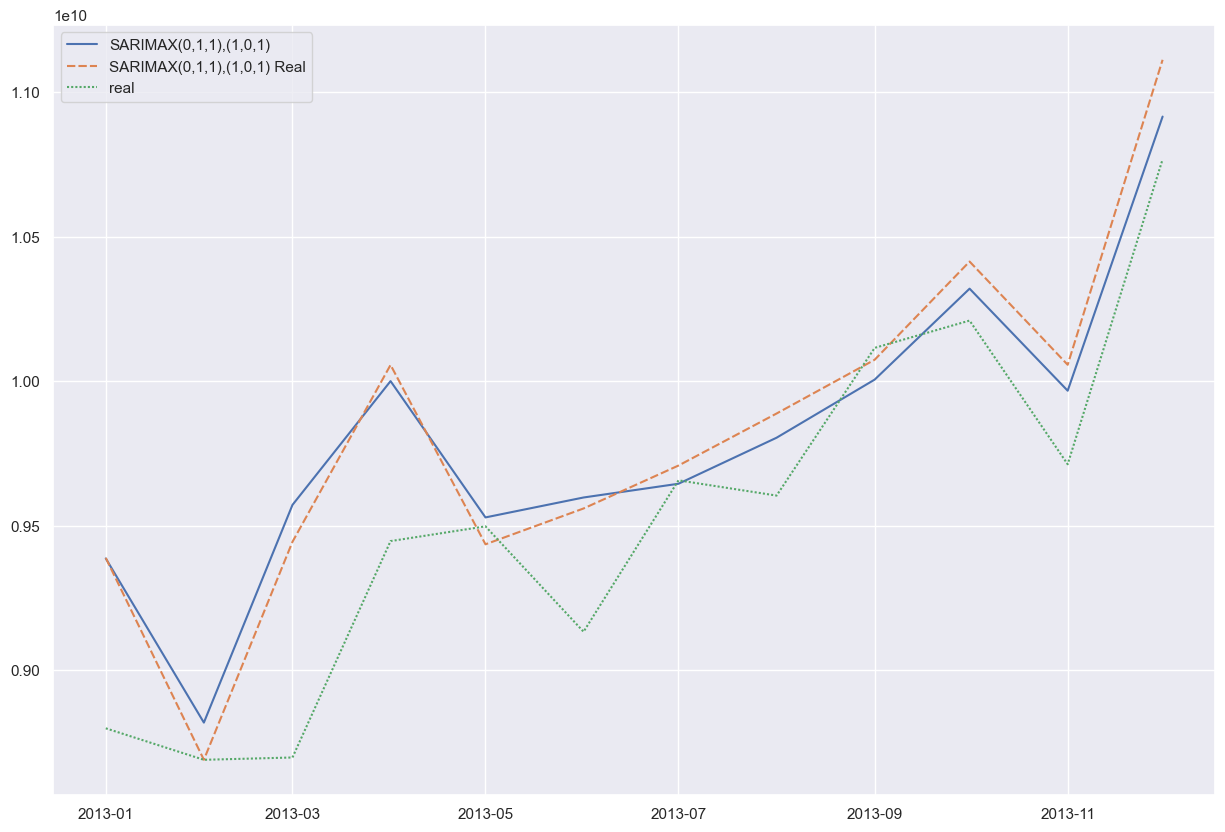

In [86]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

In [87]:
df_arima_rmse = pd.DataFrame(data=previsoes['rmse'][0:4], index= previsoes['nome'][0:4]).transpose()

In [88]:
df_arima_mape = pd.DataFrame(data=previsoes['mape'][0:4], index= previsoes['nome'][0:4]).transpose()

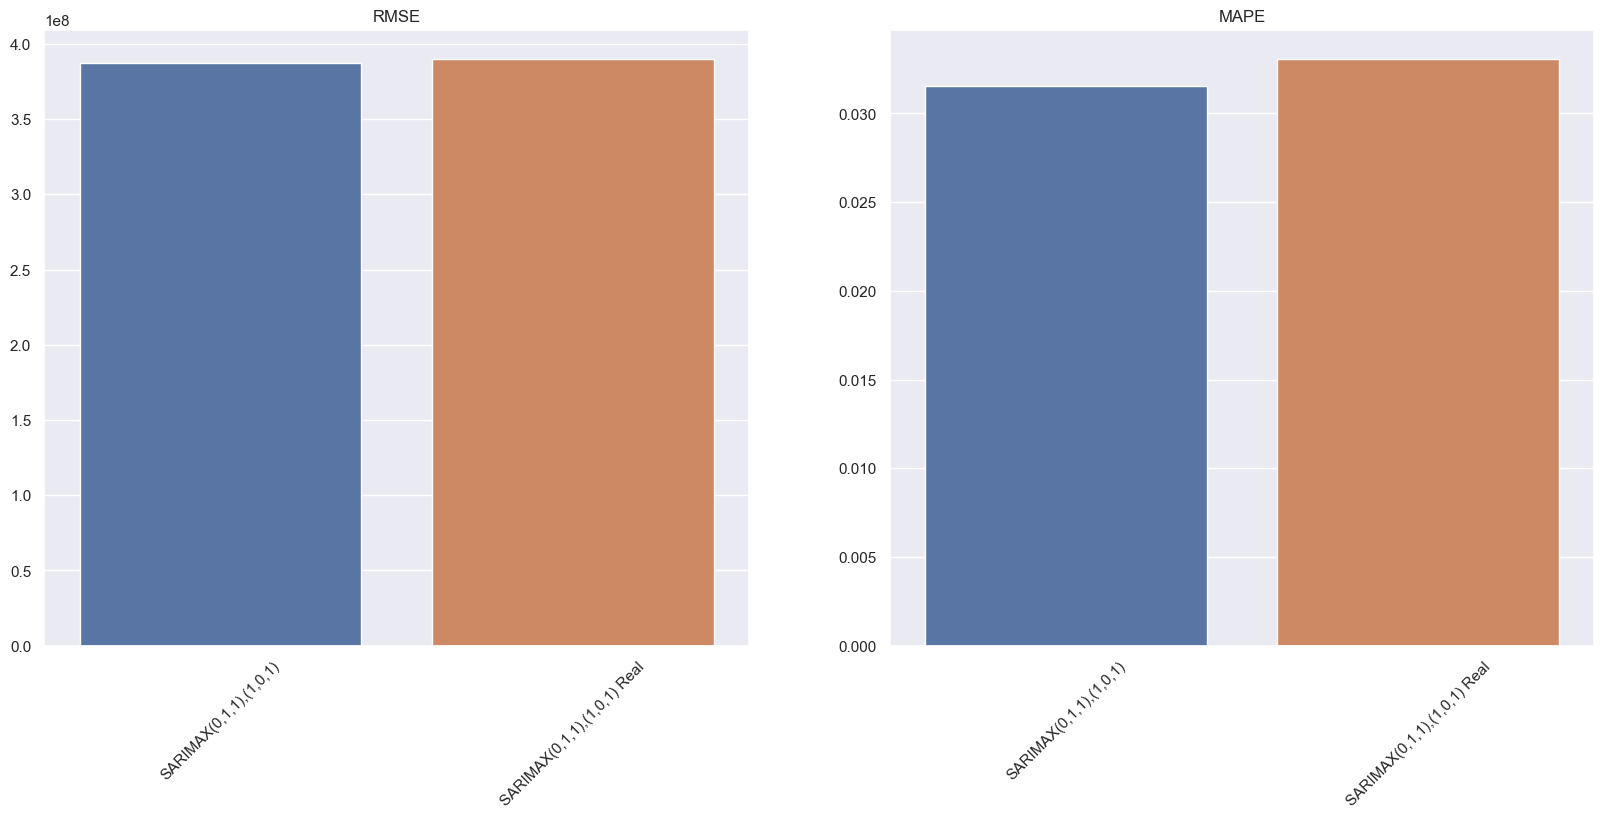

In [89]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_arima_rmse)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_arima_mape)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

## Modelo de Markov-Switching

A biblioteca statsmodel não tem implementado o método de forecast do modelo de Markov Switching. Por isso o forecast foi realizado no Ox e os dados estão sendo importados aqui.
Foram feitos 3 modelos usando as mesmas variáveis e 2 mudanças de regime:
- log icms em primeira diferença - Y
- constante - mudança de regime (*regime switching*)
- ibc-br real em primeira diferença - (*regime switching*) 
- igp-m real em segunda diferença - (*regime switching*) 
- dias úteis em nível - X (variável)
- 11 dummies sazonais centradas - X (variável)

E foram usados 3 tipos de variância
- variância fixa (*fixed variance*)
- mudança de variância (*switching variance*)
- componente média-variância (*mean-variance component*).

In [90]:
markov_forecast_df = pd.read_csv('forecast_markov.csv', delimiter=';', decimal=',')
markov_forecast_df = markov_forecast_df[-120:-108]

### Modelo com Variância Fixa

In [91]:
arq1 = open('./ox/13_results_multi_fixed_prev.txt', 'r')
print(arq1.read())
arq1.close()


Switching(31) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2012-12-01

*** Warning: there was no convergence; log-likelihood     236.996599
parameter values:
    0.0051778
     -0.11019
     -0.13125
     -0.11645
    -0.029357
    -0.083499
    -0.072552
     -0.11004
    -0.076233
    -0.045711
    -0.077302
    -0.068720
    -0.094923
     -0.12366
    0.0011668
   -0.0030755
    0.0032337
     0.011126
     0.026694
      0.64872
SQPF using analytical derivatives (eps1=0.0001; eps2=0.005):
No convergence (maximum no of iterations reached)
Used starting values:
    0.0055918     -0.12027     -0.12106     -0.10749   -0.0056037    -0.080329    -0.055355     -0.10280    -0.062606    -0.023315    -0.069099    -0.063975     -0.11098     -0.11337   0.00053897   0.00057010    0.0051669    0.0054973     0.034856      0.87201      0.71

O modelo não convergiu.

### Modelo com mudança da Variância

In [92]:
arq2 = open('./ox/13_results_multi_var_prev.txt', 'r')
print(arq2.read())
arq2.close()


Switching(32) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2012-12-01

                Coefficient   Std.Error  t-value  t-prob
dias_uteis       0.00965666    0.003953     2.44   0.016
CSeasonal         -0.131349     0.01644    -7.99   0.000
CSeasonal_1      -0.0955883     0.01522    -6.28   0.000
CSeasonal_2      -0.0480884     0.01927    -2.50   0.014
CSeasonal_3       0.0334011     0.01372     2.43   0.017
CSeasonal_4      -0.0441740     0.01602    -2.76   0.007
CSeasonal_5      -0.0235550     0.01161    -2.03   0.045
CSeasonal_6      -0.0541627     0.01477    -3.67   0.000
CSeasonal_7      -0.0310019     0.01310    -2.37   0.020
CSeasonal_8      0.00778103     0.01312    0.593   0.554
CSeasonal_9      -0.0279521     0.01275    -2.19   0.031
CSeasonal_10     -0.0186926     0.01396    -1.34   0.184
Constant(0)       -0.200967  

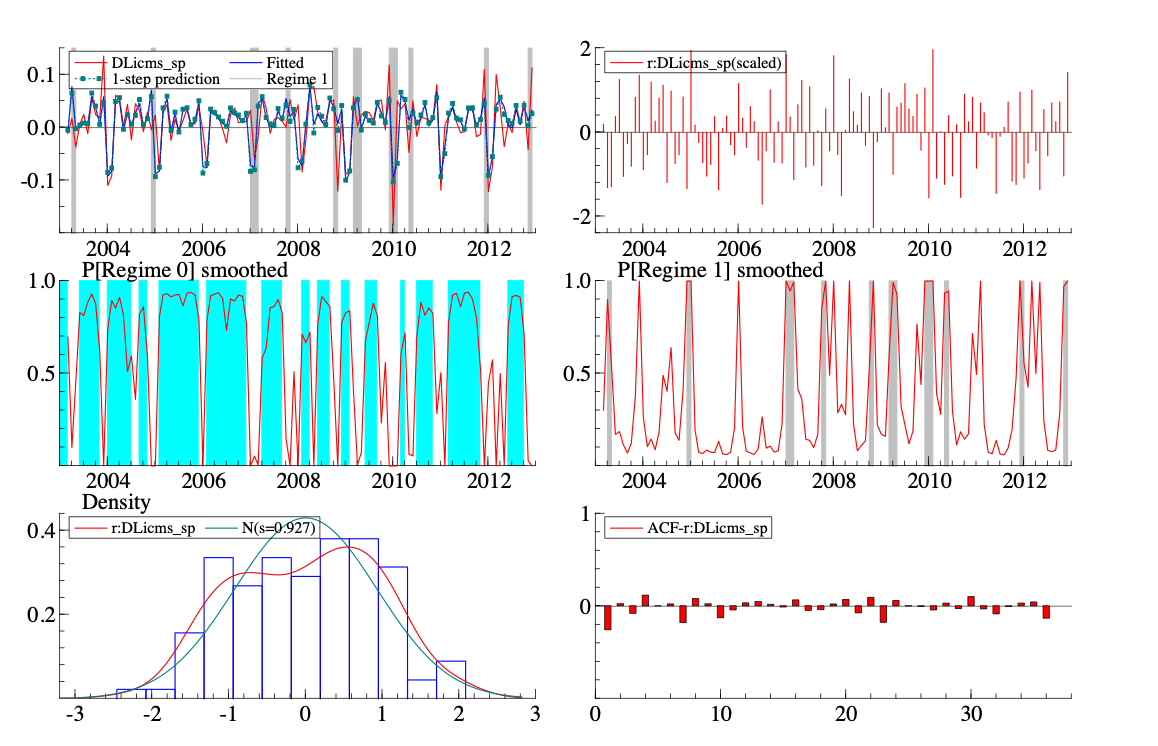

#### Previsões com Exógenas Previstas

In [93]:
y_markov_switching_pred = np.exp(np.cumsum(markov_forecast_df['13_forecast_multi_var_prev'])+icms_train[-1])
y_markov_switching_pred.index = icms_test.index
y_markov_switching_pred

date
2013-01-01    9.525869e+09
2013-02-01    8.815371e+09
2013-03-01    8.984973e+09
2013-04-01    9.726540e+09
2013-05-01    9.786724e+09
2013-06-01    9.881905e+09
2013-07-01    1.014745e+10
2013-08-01    1.040904e+10
2013-09-01    1.085945e+10
2013-10-01    1.136375e+10
2013-11-01    1.148946e+10
2013-12-01    1.191445e+10
Name: 13_forecast_multi_var_prev, dtype: float64

In [94]:
previsoes['nome'].append('Markov-Switching-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred)

In [95]:
RMSE_markov_switching = mean_squared_error(icms_test, y_markov_switching_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_switching)
RMSE_markov_switching

846172491.2499248

In [96]:
MAPE_markov_switching = mean_absolute_percentage_error(icms_test, y_markov_switching_pred)
previsoes['mape'].append(MAPE_markov_switching)
MAPE_markov_switching

0.0735315880182932

In [97]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred, icms_test)])

#### Previsões com Exógenas Reais

In [98]:
y_markov_switching_pred_r = np.exp(np.cumsum(markov_forecast_df['13_forecast_multi_var'])+icms_train[-1])
y_markov_switching_pred_r.index = icms_test.index
y_markov_switching_pred_r

date
2013-01-01    1.011231e+10
2013-02-01    9.190151e+09
2013-03-01    9.361872e+09
2013-04-01    1.022556e+10
2013-05-01    1.009006e+10
2013-06-01    1.006722e+10
2013-07-01    1.040724e+10
2013-08-01    1.057110e+10
2013-09-01    1.094178e+10
2013-10-01    1.156533e+10
2013-11-01    1.157656e+10
2013-12-01    1.197822e+10
Name: 13_forecast_multi_var, dtype: float64

In [99]:
previsoes['nome'].append('Markov-Switching-Var Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred_r)

In [100]:
RMSE_markov_switching_r = mean_squared_error(icms_test, y_markov_switching_pred_r, squared=False)
previsoes['rmse'].append(RMSE_markov_switching_r)
RMSE_markov_switching_r

1048774039.1128538

In [101]:
MAPE_markov_switching_r = mean_absolute_percentage_error(icms_test, y_markov_switching_pred_r)
previsoes['mape'].append(MAPE_markov_switching_r)
MAPE_markov_switching_r

0.10225652406699115

In [102]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred_r, icms_test)])

### Componente Média-Variância

In [103]:
arq3 = open('./ox/13_results_multi_mean_var_prev.txt', 'r')
print(arq3.read())
arq3.close()


Switching(33) Modelling DLicms_sp by MS_Component(2, 2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/revisao/ox/variaveis_previsao_markov.xlsx
              The estimation sample is: 2003-03-01 - 2012-12-01

                Coefficient   Std.Error  t-value  t-prob
dias_uteis       0.00762462   8.397e-05     90.8   0.000
CSeasonal         -0.132364    0.001586    -83.5   0.000
CSeasonal_1       -0.113580    0.002205    -51.5   0.000
CSeasonal_2      -0.0490549    0.002873    -17.1   0.000
CSeasonal_3     -0.00530778    0.001637    -3.24   0.002
CSeasonal_4      -0.0783592    0.001609    -48.7   0.000
CSeasonal_5      -0.0483666    0.001602    -30.2   0.000
CSeasonal_6      -0.0805952    0.002638    -30.6   0.000
CSeasonal_7      -0.0485123    0.002298    -21.1   0.000
CSeasonal_8     -0.00504864    0.001689    -2.99   0.004
CSeasonal_9      -0.0480997    0.002005    -24.0   0.000
CSeasonal_10     -0.0477585    0.001748    -27.3   0.000
Constant(0)     

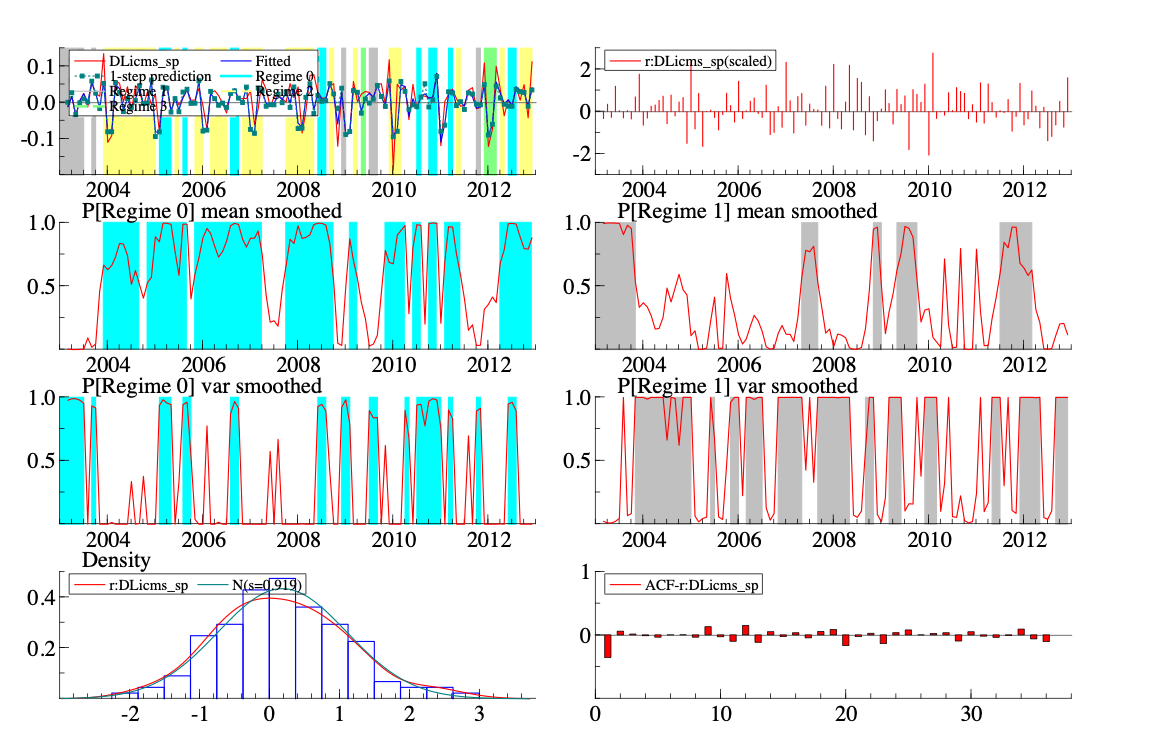

#### Previsões com Exógenas Previstas

In [104]:
y_markov_mean_var_pred = np.exp(np.cumsum(markov_forecast_df['13_forecast_multi_mean_var_prev'])+icms_train[-1])
y_markov_mean_var_pred.index = icms_test.index
y_markov_mean_var_pred

date
2013-01-01    9.562413e+09
2013-02-01    8.813939e+09
2013-03-01    9.043371e+09
2013-04-01    9.486146e+09
2013-05-01    9.302260e+09
2013-06-01    9.261482e+09
2013-07-01    9.301341e+09
2013-08-01    9.437837e+09
2013-09-01    9.804901e+09
2013-10-01    1.009375e+10
2013-11-01    1.001373e+10
2013-12-01    1.047089e+10
Name: 13_forecast_multi_mean_var_prev, dtype: float64

In [105]:
previsoes['nome'].append('Markov-Mean-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred)

In [106]:
RMSE_markov_mean_var = mean_squared_error(icms_test, y_markov_mean_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var)
RMSE_markov_mean_var

318263062.5561902

In [107]:
MAPE_markov_mean_var = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred)
previsoes['mape'].append(MAPE_markov_mean_var)
MAPE_markov_mean_var

0.027844448172713237

In [108]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred, icms_test)])

#### Previsões com Exógenas Reais

In [109]:
y_markov_mean_var_pred_r = np.exp(np.cumsum(markov_forecast_df['13_forecast_multi_mean_var'])+icms_train[-1])
y_markov_mean_var_pred_r.index = icms_test.index
y_markov_mean_var_pred_r

date
2013-01-01    9.571332e+09
2013-02-01    8.761304e+09
2013-03-01    9.003573e+09
2013-04-01    9.560446e+09
2013-05-01    9.264689e+09
2013-06-01    9.203132e+09
2013-07-01    9.273421e+09
2013-08-01    9.391739e+09
2013-09-01    9.756514e+09
2013-10-01    1.009215e+10
2013-11-01    9.978907e+09
2013-12-01    1.049108e+10
Name: 13_forecast_multi_mean_var, dtype: float64

In [110]:
previsoes['nome'].append('Markov-Mean-Var Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred_r)

In [111]:
RMSE_markov_mean_var_r = mean_squared_error(icms_test, y_markov_mean_var_pred_r, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var_r)
RMSE_markov_mean_var_r

322565103.70116323

In [112]:
MAPE_markov_mean_var_r = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred_r)
previsoes['mape'].append(MAPE_markov_mean_var_r)
MAPE_markov_mean_var_r

0.028093137109432283

In [113]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred_r, icms_test)])

### Comparação dos Modelos de Markov com Endógenas Previstas e Reais

In [114]:
previsoes['nome']

['SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Switching-Var',
 'Markov-Switching-Var Real',
 'Markov-Mean-Var',
 'Markov-Mean-Var Real']

In [115]:
prev_markov_df = pd.DataFrame(data={previsoes['nome'][2]: previsoes['previsoes'][2],
                                    previsoes['nome'][3]: previsoes['previsoes'][3],
                                    previsoes['nome'][4]: previsoes['previsoes'][4],
                                    previsoes['nome'][5]: previsoes['previsoes'][5]
                                   })
prev_markov_df['real'] = icms_test
prev_markov_df

Markov-Switching-Var  Markov-Switching-Var Real  Markov-Mean-Var  \
date                                                                           
2013-01-01          9.525869e+09               1.011231e+10     9.562413e+09   
2013-02-01          8.815371e+09               9.190151e+09     8.813939e+09   
2013-03-01          8.984973e+09               9.361872e+09     9.043371e+09   
2013-04-01          9.726540e+09               1.022556e+10     9.486146e+09   
2013-05-01          9.786724e+09               1.009006e+10     9.302260e+09   
2013-06-01          9.881905e+09               1.006722e+10     9.261482e+09   
2013-07-01          1.014745e+10               1.040724e+10     9.301341e+09   
2013-08-01          1.040904e+10               1.057110e+10     9.437837e+09   
2013-09-01          1.085945e+10               1.094178e+10     9.804901e+09   
2013-10-01          1.136375e+10               1.156533e+10     1.009375e+10   
2013-11-01          1.148946e+10               1.157656e+10     1.001373e+10   
2013-12-01          1.191445e+10               1.197822e+10     1.047089e+10   

            Markov-Mean-Var Real          real  
date                                            
2013-01-01          9.571332e+09  8.799359e+09  
2013-02-01          8.761304e+09  8.690433e+09  
2013-03-01          9.003573e+09  8.698445e+09  
2013-04-01          9.560446e+09  9.446984e+09  
2013-05-01          9.264689e+09  9.497989e+09  
2013-06-01          9.203132e+09  9.133477e+09  
2013-07-01          9.273421e+09  9.657129e+09  
2013-08-01          9.391739e+09  9.604407e+09  
2013-09-01          9.756514e+09  1.011536e+10  
2013-10-01          1.009215e+10  1.020979e+10  
2013-11-01          9.978907e+09  9.712795e+09  
2013-12-01          1.049108e+10  1.076762e+10

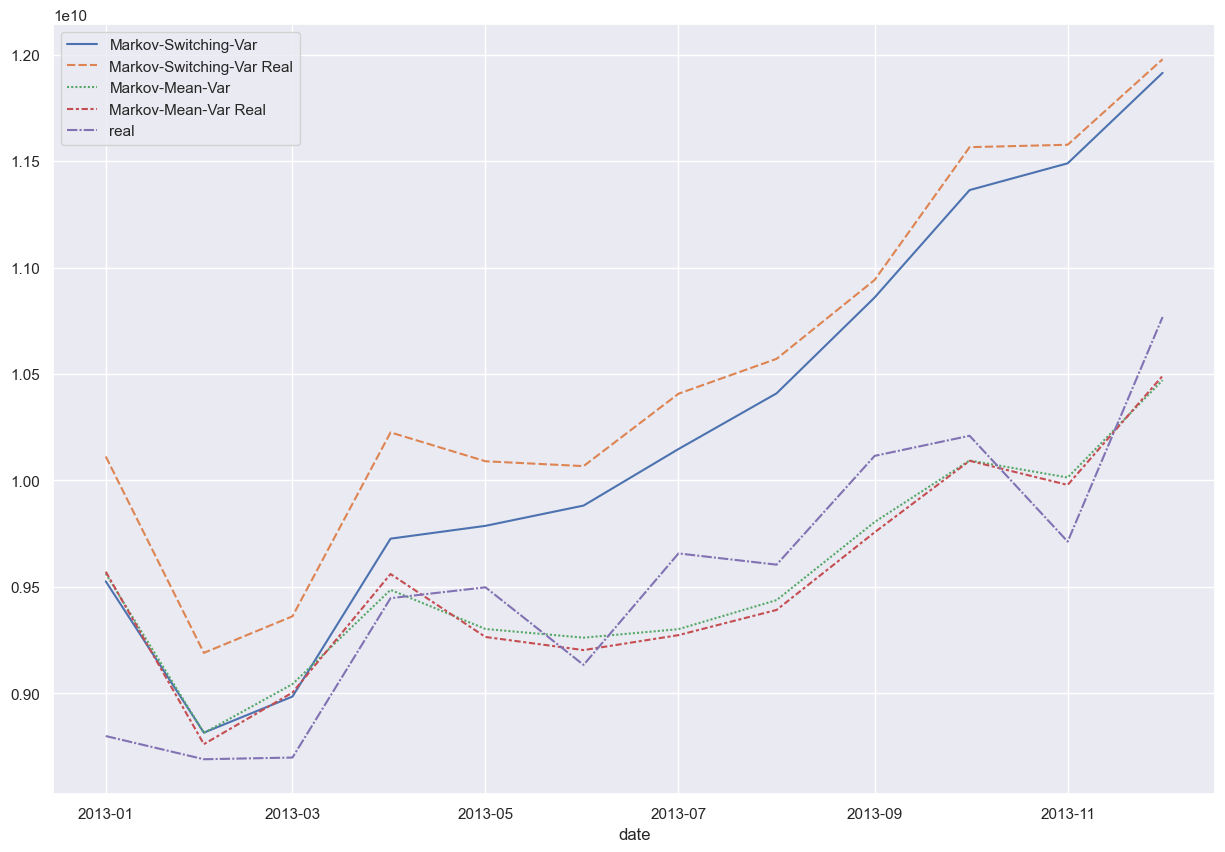

In [116]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_markov_df)

In [117]:
df_markov_rmse = pd.DataFrame(data=previsoes['rmse'][2:6], index= previsoes['nome'][2:6]).transpose()

In [118]:
df_markov_mape = pd.DataFrame(data=previsoes['mape'][2:6], index= previsoes['nome'][2:6]).transpose()

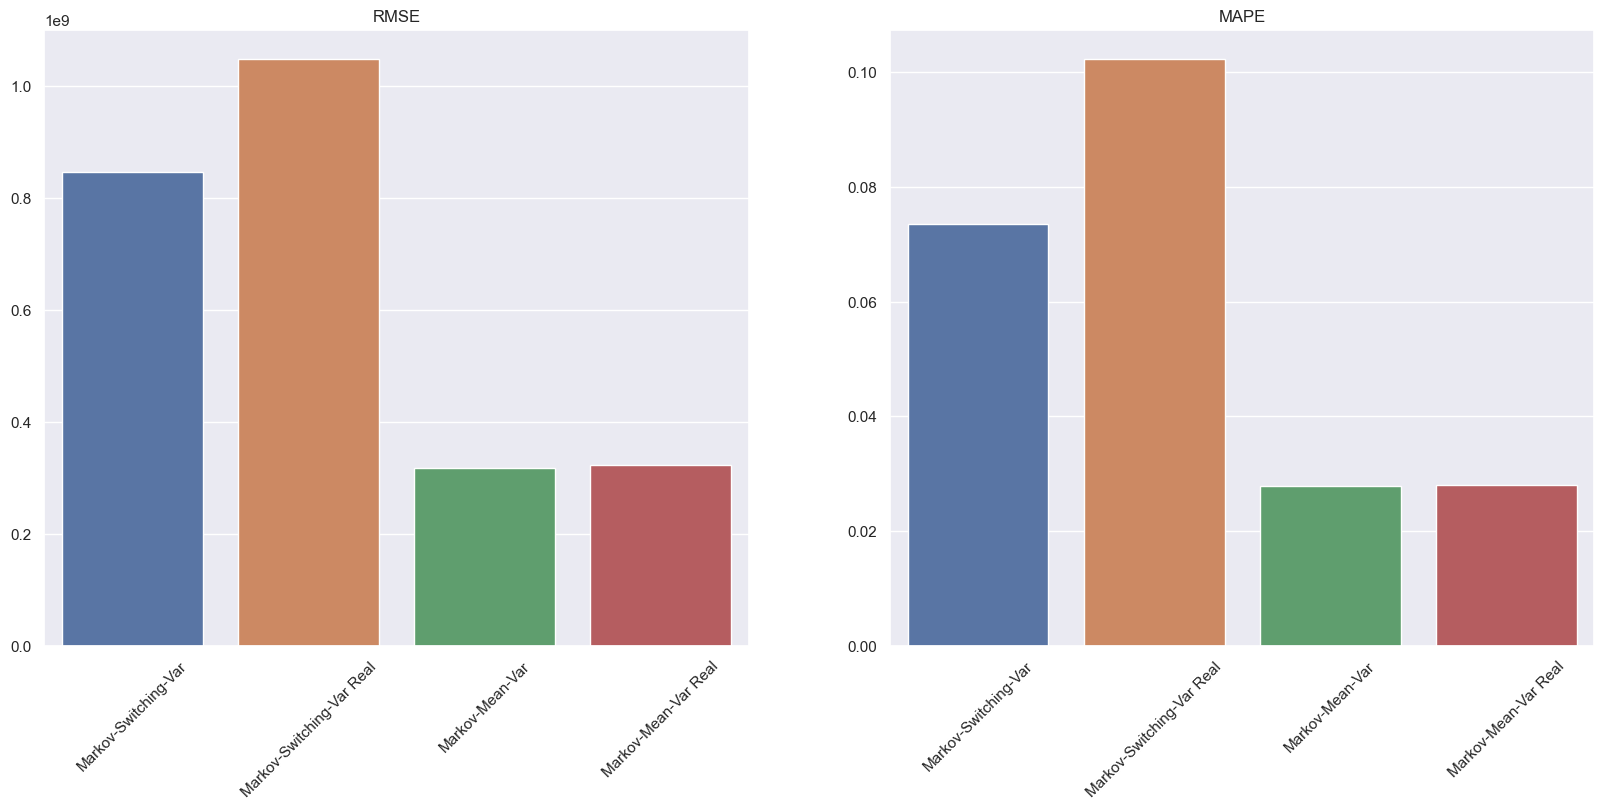

In [119]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_markov_rmse)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_markov_mape)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série com as Variáveis Exógenas Previstas.
As redes neurais precisam de conjuntos de características e de etiquetas separados. As variáveis exógenas serão o conjunto de características e a variável endógena será o conjunto de etiquetas.

In [120]:
X_data = np.append(exog[:,:4], np.roll(exog[:,:4], 1, axis = 0), axis = 1)
X_data = np.append(X_data, np.roll(exog[:,:4], 2, axis = 0), axis = 1)[2:]
Y_data = icms_ts[2:].to_numpy()

In [121]:
X_data.shape, Y_data.shape

((130, 12), (130,))

### Montagem da Série com as Variáveis Exógenas Reais

In [126]:
X_reais_data = np.append(exog_reais[:,:4], np.roll(exog_reais[:,:4], 1, axis = 0), axis = 1)
X_reais_data = np.append(X_reais_data, np.roll(exog_reais[:,:4], 2, axis = 0), axis = 1)[2:]

In [127]:
X_reais_data.shape

(130, 12)

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [128]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
Y_train = Y_data[:-24]
Y_val = Y_data[-24:-12]
Y_test = np.exp(Y_data[-12:]) # tirando o log
print(Y_train.shape, Y_val.shape, Y_test.shape)

(106, 12) (12, 12) (12, 12)
(106,) (12,) (12,)


In [129]:
X_reais_test = X_reais_data[-12:]
print(X_reais_test.shape)

(12, 12)


In [130]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(X_train.shape[1]))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)
X_reais_test_std = enc_x.transform(X_reais_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)
print(X_reais_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(106, 12)
(12, 12)
(12, 12)
(12, 12)


In [131]:
x_train = X_train_std.reshape(X_train_std.shape[0], X_train_std.shape[1], 1)
x_val = X_val_std.reshape(X_val_std.shape[0], X_val_std.shape[1], 1)
x_test = X_test_std.reshape(X_test_std.shape[0], X_test_std.shape[1], 1)
x_reais_test = X_reais_test_std.reshape(X_reais_test_std.shape[0], X_reais_test_std.shape[1], 1)
print(x_train.shape, x_val.shape, x_test.shape, x_reais_test.shape)

y_train = Y_train.reshape(Y_train.shape[0], 1)
y_val = Y_val.reshape(Y_val.shape[0], 1)
y_test = Y_test.reshape(Y_test.shape[0], 1)
print(y_train.shape, y_val.shape, y_test.shape)

(106, 12, 1) (12, 12, 1) (12, 12, 1) (12, 12, 1)
(106, 1) (12, 1) (12, 1)


### Criando o modelo LSTM

In [132]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [133]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [134]:
# Épocas
EPOCHS = 1000
NEURONIOS = 600
DROPOUT = 0.15
LR = 1e-5
BATCH = 8

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (12, 1), return_sequences = True,
        units = NEURONIOS))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (12, 1), return_sequences = True,
        units = NEURONIOS))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (12, 1), return_sequences = False,
        units = NEURONIOS))

# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=LR))

In [135]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 600)           1444800   
                                                                 
 lstm_1 (LSTM)               (None, 12, 600)           2882400   
                                                                 
 lstm_2 (LSTM)               (None, 600)               2882400   
                                                                 
 dense (Dense)               (None, 1)                 601       
                                                                 
Total params: 7210201 (27.50 MB)
Trainable params: 7210201 (27.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [136]:
# History object for plotting our model loss by epoch
history = model.fit(x_train, y_train, batch_size = BATCH, 
                    epochs = EPOCHS, validation_data = (x_val, y_val),
                    callbacks = [rlrop, early_stop])

Epoch 1/1000
14/14 [==============================] - 9s 255ms/step - loss: 99.9320 - val_loss: 99.7288 - lr: 1.0000e-05
Epoch 2/1000
14/14 [==============================] - 2s 140ms/step - loss: 99.7141 - val_loss: 99.3806 - lr: 1.0000e-05
Epoch 3/1000
14/14 [==============================] - 2s 145ms/step - loss: 99.4388 - val_loss: 98.8949 - lr: 1.0000e-05
Epoch 4/1000
14/14 [==============================] - 2s 140ms/step - loss: 99.0672 - val_loss: 98.1374 - lr: 1.0000e-05
Epoch 5/1000
14/14 [==============================] - 2s 161ms/step - loss: 98.3635 - val_loss: 96.7859 - lr: 1.0000e-05
Epoch 6/1000
14/14 [==============================] - 3s 183ms/step - loss: 97.1902 - val_loss: 94.1844 - lr: 1.0000e-05
Epoch 7/1000
14/14 [==============================] - 2s 174ms/step - loss: 94.7845 - val_loss: 88.6645 - lr: 1.0000e-05
Epoch 8/1000
14/14 [==============================] - 2s 168ms/step - loss: 89.6029 - val_loss: 75.5864 - lr: 1.0000e-05
Epoch 9/1000
14/14 [============

14/14 [==============================] - 2s 166ms/step - loss: 0.8651 - val_loss: 0.9685 - lr: 1.0000e-06
Epoch 70/1000
14/14 [==============================] - 2s 156ms/step - loss: 0.9952 - val_loss: 0.9433 - lr: 1.0000e-06
Epoch 71/1000
14/14 [==============================] - 3s 189ms/step - loss: 0.9071 - val_loss: 0.8266 - lr: 1.0000e-06
Epoch 72/1000
14/14 [==============================] - 2s 158ms/step - loss: 0.7558 - val_loss: 0.8230 - lr: 1.0000e-06
Epoch 73/1000
14/14 [==============================] - 2s 138ms/step - loss: 0.8448 - val_loss: 0.7111 - lr: 1.0000e-06
Epoch 74/1000
14/14 [==============================] - 2s 137ms/step - loss: 0.8902 - val_loss: 0.7744 - lr: 1.0000e-06
Epoch 75/1000
14/14 [==============================] - 2s 141ms/step - loss: 0.7805 - val_loss: 0.8270 - lr: 1.0000e-06
Epoch 76/1000
14/14 [==============================] - 3s 190ms/step - loss: 0.8489 - val_loss: 0.8741 - lr: 1.0000e-06
Epoch 77/1000
14/14 [==============================] -

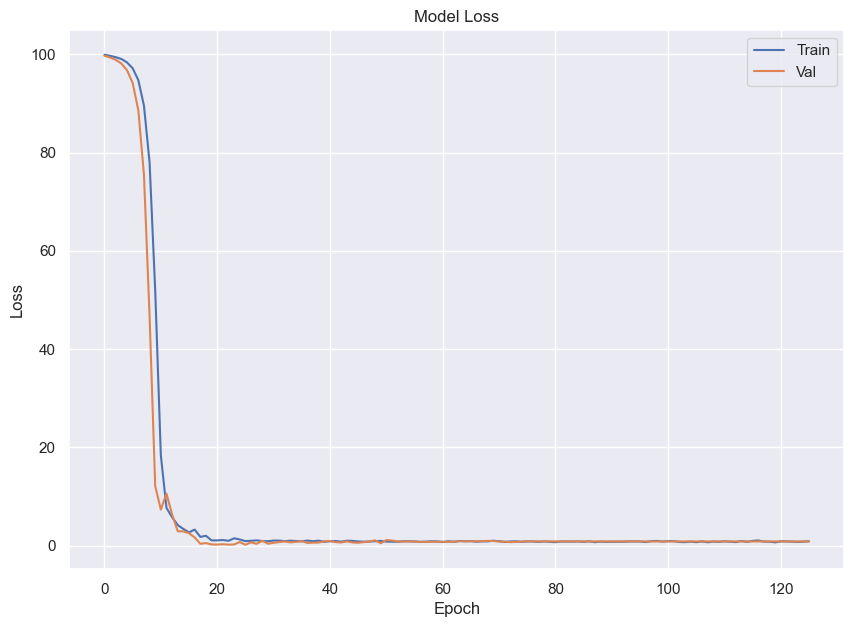

In [137]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão 12 meses em Teste com Exógenas Previstas

In [138]:
Y_pred1 = np.exp(model.predict(x_test))

1/1 [==============================] - 1s 1s/step


In [139]:
y_pred1 = pd.Series(Y_pred1.ravel())
y_pred1.index = icms_ts.index[-12:]
y_pred1

date
2013-01-01    8742386688
2013-02-01    8345878016
2013-03-01    8735536128
2013-04-01    8988795904
2013-05-01    9015341056
2013-06-01    8904838144
2013-07-01    9242750976
2013-08-01    9291536384
2013-09-01    9156718592
2013-10-01    9321944064
2013-11-01    9108919296
2013-12-01    9061784576
Name: RNN-LSTM, dtype: int64

In [140]:
RMSE_lstm1 = mean_squared_error(y_test, y_pred1, squared=False)
RMSE_lstm1

699398257.3687475

In [141]:
MAPE_lstm1 = mean_absolute_percentage_error(y_test, y_pred1)
MAPE_lstm1

0.05437897215742641

In [142]:
previsoes['nome'].append('RNN-LSTM')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(y_pred1)
previsoes['rmse'].append(RMSE_lstm1)
previsoes['mape'].append(MAPE_lstm1)
previsoes['aic'].append(0)
previsoes['bic'].append(0)

In [143]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred1, y_test)])

### Previsão 12 meses em Teste com Exógenas Reais

In [144]:
Y_pred2 = np.exp(model.predict(x_reais_test))

1/1 [==============================] - 0s 47ms/step


In [145]:
y_pred2 = pd.Series(Y_pred2.ravel())
y_pred2.index = icms_ts.index[-12:]
y_pred2

date
2013-01-01    8745871000
2013-02-01    8237798000
2013-03-01    8629055000
2013-04-01    8992276000
2013-05-01    8974543000
2013-06-01    8866873000
2013-07-01    9255682000
2013-08-01    9328881000
2013-09-01    9195239000
2013-10-01    9367393000
2013-11-01    9161330000
2013-12-01    9157346000
Name: RNN-LSTM-Real, dtype: int64

In [146]:
RMSE_lstm2 = mean_squared_error(y_test, y_pred2, squared=False)
RMSE_lstm2

674215972.1343801

In [147]:
MAPE_lstm2 = mean_absolute_percentage_error(y_test, y_pred2)
MAPE_lstm2

0.05405228687580745

In [148]:
previsoes['nome'].append('RNN-LSTM-Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_pred2)
previsoes['rmse'].append(RMSE_lstm2)
previsoes['mape'].append(MAPE_lstm2)
previsoes['aic'].append(0)
previsoes['bic'].append(0)

In [149]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred2, y_test)])

## Resultados

In [150]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["Real"] = icms_test
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [151]:
df_prev

SARIMAX(0,1,1),(1,0,1)  SARIMAX(0,1,1),(1,0,1) Real  \
2013-01-01            9.386985e+09                 9.388726e+09   
2013-02-01            8.819138e+09                 8.690533e+09   
2013-03-01            9.572178e+09                 9.444546e+09   
2013-04-01            1.000040e+10                 1.005633e+10   
2013-05-01            9.528873e+09                 9.435868e+09   
2013-06-01            9.597817e+09                 9.559843e+09   
2013-07-01            9.645359e+09                 9.708326e+09   
2013-08-01            9.804562e+09                 9.888305e+09   
2013-09-01            1.000559e+10                 1.007430e+10   
2013-10-01            1.032016e+10                 1.041396e+10   
2013-11-01            9.967158e+09                 1.005687e+10   
2013-12-01            1.091537e+10                 1.111181e+10   

            Markov-Switching-Var  Markov-Switching-Var Real  Markov-Mean-Var  \
2013-01-01          9.525869e+09               1.011231e+10     9.562413e+09   
2013-02-01          8.815371e+09               9.190151e+09     8.813939e+09   
2013-03-01          8.984973e+09               9.361872e+09     9.043371e+09   
2013-04-01          9.726540e+09               1.022556e+10     9.486146e+09   
2013-05-01          9.786724e+09               1.009006e+10     9.302260e+09   
2013-06-01          9.881905e+09               1.006722e+10     9.261482e+09   
2013-07-01          1.014745e+10               1.040724e+10     9.301341e+09   
2013-08-01          1.040904e+10               1.057110e+10     9.437837e+09   
2013-09-01          1.085945e+10               1.094178e+10     9.804901e+09   
2013-10-01          1.136375e+10               1.156533e+10     1.009375e+10   
2013-11-01          1.148946e+10               1.157656e+10     1.001373e+10   
2013-12-01          1.191445e+10               1.197822e+10     1.047089e+10   

            Markov-Mean-Var Real      RNN-LSTM  RNN-LSTM-Real          Real  
2013-01-01          9.571332e+09  8.742387e+09   8.745871e+09  8.799359e+09  
2013-02-01          8.761304e+09  8.345878e+09   8.237798e+09  8.690433e+09  
2013-03-01          9.003573e+09  8.735536e+09   8.629055e+09  8.698445e+09  
2013-04-01          9.560446e+09  8.988796e+09   8.992276e+09  9.446984e+09  
2013-05-01          9.264689e+09  9.015341e+09   8.974543e+09  9.497989e+09  
2013-06-01          9.203132e+09  8.904838e+09   8.866873e+09  9.133477e+09  
2013-07-01          9.273421e+09  9.242751e+09   9.255682e+09  9.657129e+09  
2013-08-01          9.391739e+09  9.291536e+09   9.328881e+09  9.604407e+09  
2013-09-01          9.756514e+09  9.156719e+09   9.195239e+09  1.011536e+10  
2013-10-01          1.009215e+10  9.321944e+09   9.367393e+09  1.020979e+10  
2013-11-01          9.978907e+09  9.108919e+09   9.161330e+09  9.712795e+09  
2013-12-01          1.049108e+10  9.061785e+09   9.157346e+09  1.076762e+10

In [152]:
df_erro

SARIMAX(0,1,1),(1,0,1) SARIMAX(0,1,1),(1,0,1) Real Markov-Switching-Var  \
0                6.678049                    6.697833             8.256388   
1                1.480993                    0.001142             1.437644   
2               10.044709                     8.57741             3.294011   
3                 5.85812                    6.450171              2.95921   
4                0.325164                    0.654043             3.039959   
5                5.083937                    4.668174             8.194345   
6                0.121872                    0.530147             5.077309   
7                2.083989                    2.955914             8.377747   
8                1.085192                    0.405875             7.356051   
9                1.081005                     1.99978            11.302505   
10               2.618845                    3.542486            18.291999   
11               1.372184                    3.196518            10.650737   

   Markov-Switching-Var Real Markov-Mean-Var Markov-Mean-Var Real  \
0                  14.921035        8.671694             8.773058   
1                   5.750208        1.421165             0.815497   
2                   7.626964        3.965379             3.507843   
3                    8.24152        0.414549             1.201039   
4                   6.233597        2.060741             2.456308   
5                  10.223263        1.401492             0.762633   
6                   7.767474        3.684196             3.973308   
7                  10.065136        1.734312             2.214272   
8                    8.16997        3.069178             3.547531   
9                  13.276932         1.13656             1.152232   
10                 19.188762        3.098296             2.739815   
11                 11.242968        2.755774              2.56823   

                RNN-LSTM         RNN-LSTM-Real  
0   [0.6474642311764234]  [0.6078668940916993]  
1    [3.964766173293037]   [5.208432758001748]  
2    [0.426411517390718]  [0.7977282975758804]  
3    [4.850096257992938]   [4.813258087124513]  
4    [5.081578104275202]   [5.511122263268072]  
5   [2.5033032501233805]  [2.9189734814938877]  
6    [4.290901220219047]   [4.156999889700314]  
7    [3.257572301178824]  [2.8687443760639324]  
8    [9.477082092793976]   [9.096271030828769]  
9    [8.696003138931623]   [8.250852483511116]  
10   [6.217320919157093]   [5.677716156625991]  
11  [15.842267382379438]   [14.95477853268301]

### Resultados Apenas das Redes Neurais

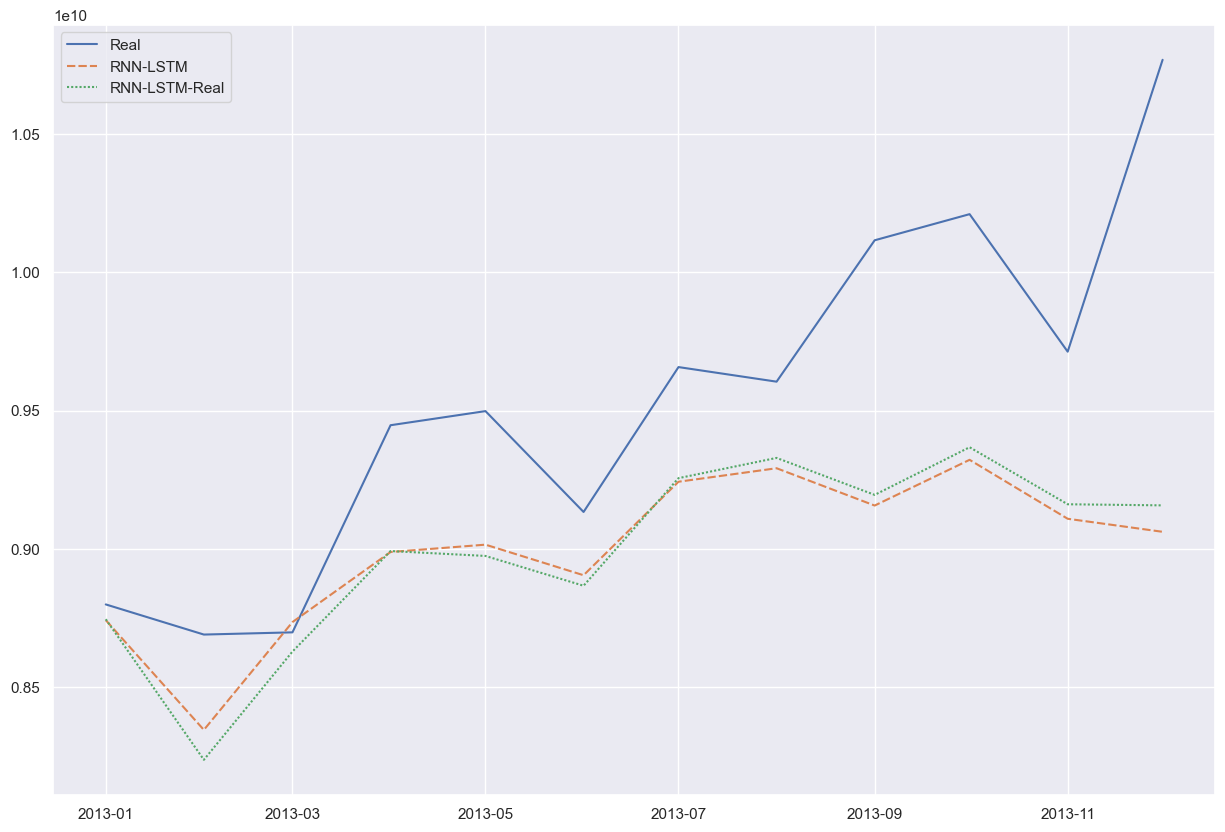

In [153]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev[['Real', 'RNN-LSTM', 'RNN-LSTM-Real']])

In [154]:
df_rmse_lstm = df_rmse[['RNN-LSTM', 'RNN-LSTM-Real']]
df_mape_lstm = df_mape[['RNN-LSTM', 'RNN-LSTM-Real']]

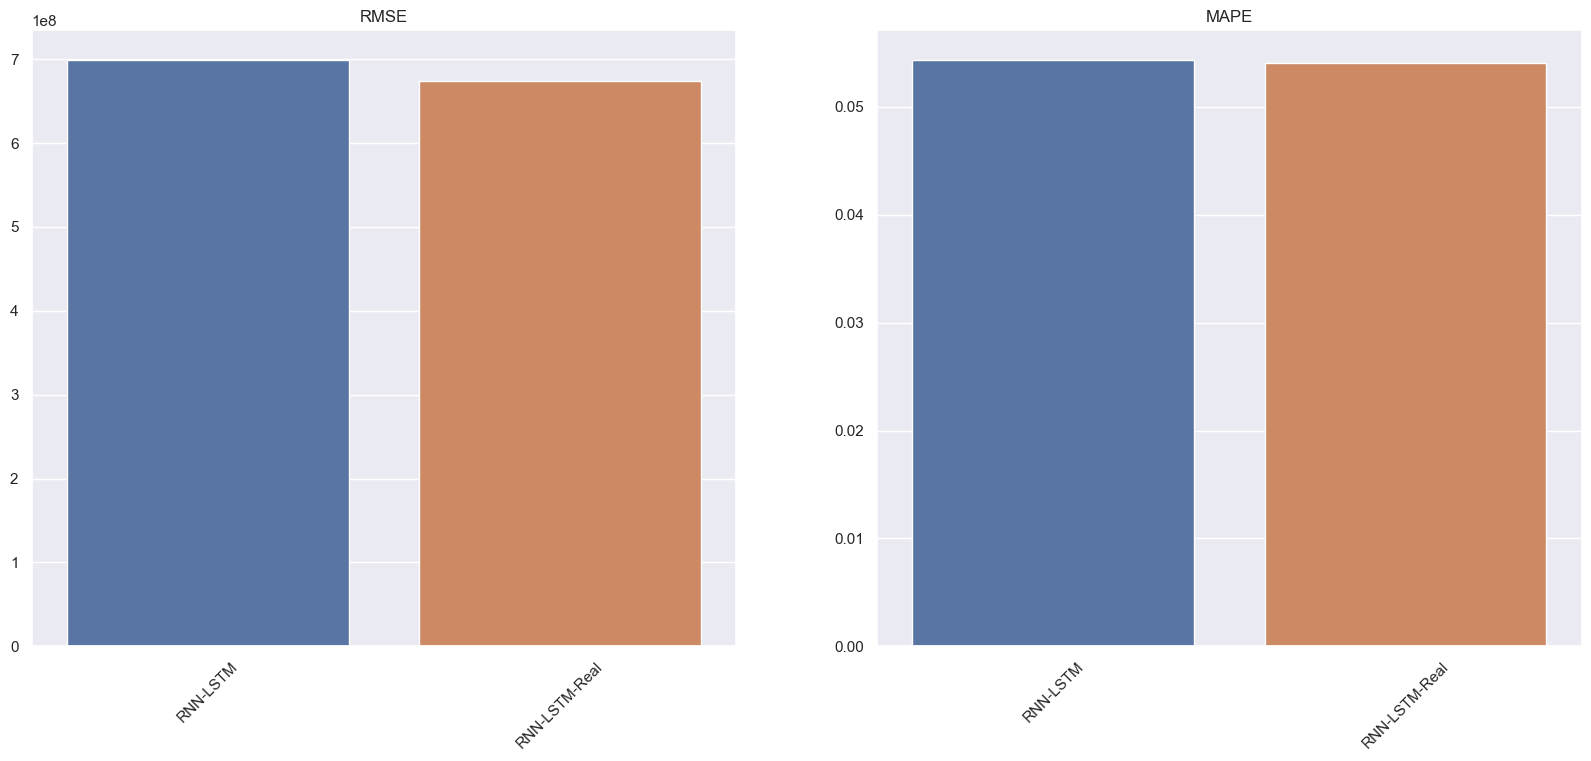

In [155]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_rmse_lstm)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_mape_lstm)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

### Resultados Gerais com os Dados Previstos

In [156]:
previsoes['nome']

['SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Switching-Var',
 'Markov-Switching-Var Real',
 'Markov-Mean-Var',
 'Markov-Mean-Var Real',
 'RNN-LSTM',
 'RNN-LSTM-Real']

#### Previsões com os Dados Previstos

In [157]:
df_prev_prev = df_prev[['SARIMAX(0,1,1),(1,0,1)',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM', 'Real']]

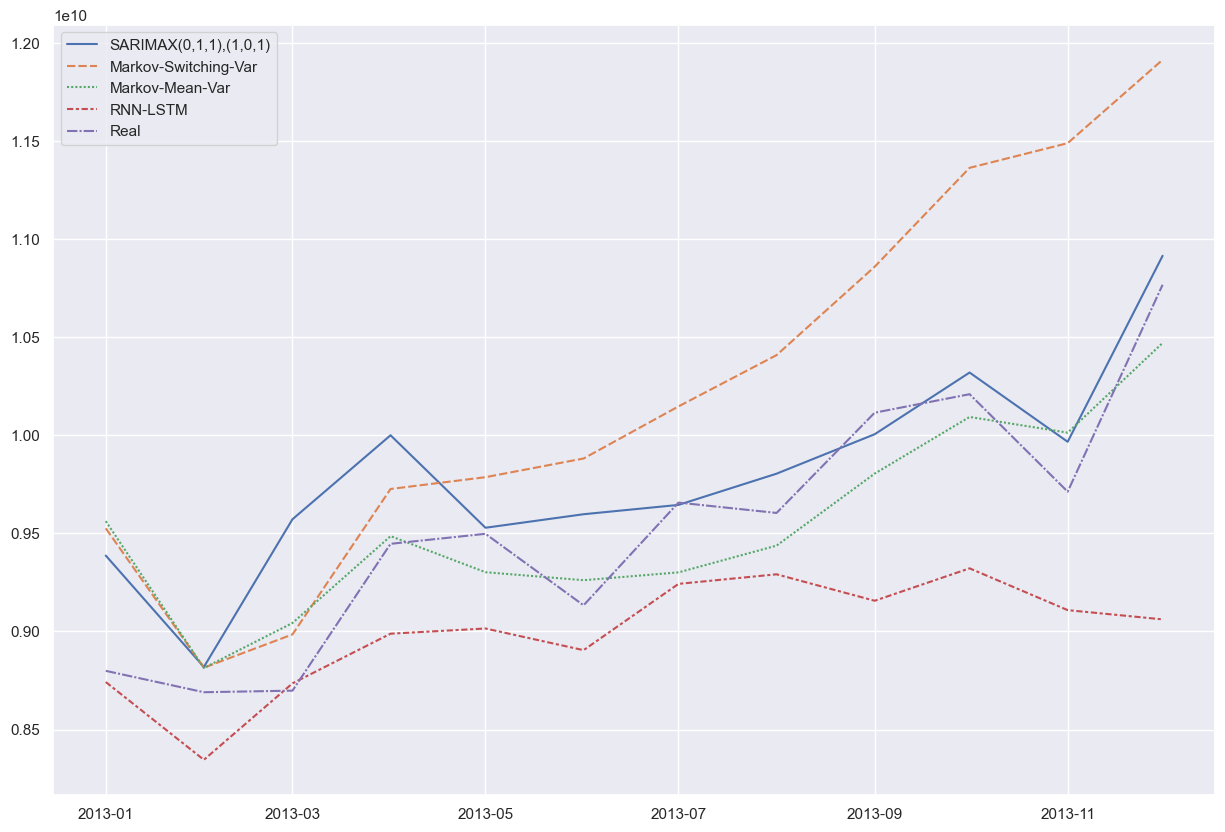

In [158]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev_prev)

#### RMSE com Dados Previstos

In [159]:
previsoes['nome']

['SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Switching-Var',
 'Markov-Switching-Var Real',
 'Markov-Mean-Var',
 'Markov-Mean-Var Real',
 'RNN-LSTM',
 'RNN-LSTM-Real']

In [160]:
df_rmse

SARIMAX(0,1,1),(1,0,1)  SARIMAX(0,1,1),(1,0,1) Real  Markov-Switching-Var  \
0            3.871989e+08                 3.899162e+08          8.461725e+08   

   Markov-Switching-Var Real  Markov-Mean-Var  Markov-Mean-Var Real  \
0               1.048774e+09     3.182631e+08          3.225651e+08   

       RNN-LSTM  RNN-LSTM-Real  
0  6.993983e+08   6.742160e+08

In [161]:
df_rmse_prev = df_rmse[['SARIMAX(0,1,1),(1,0,1)',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM']]

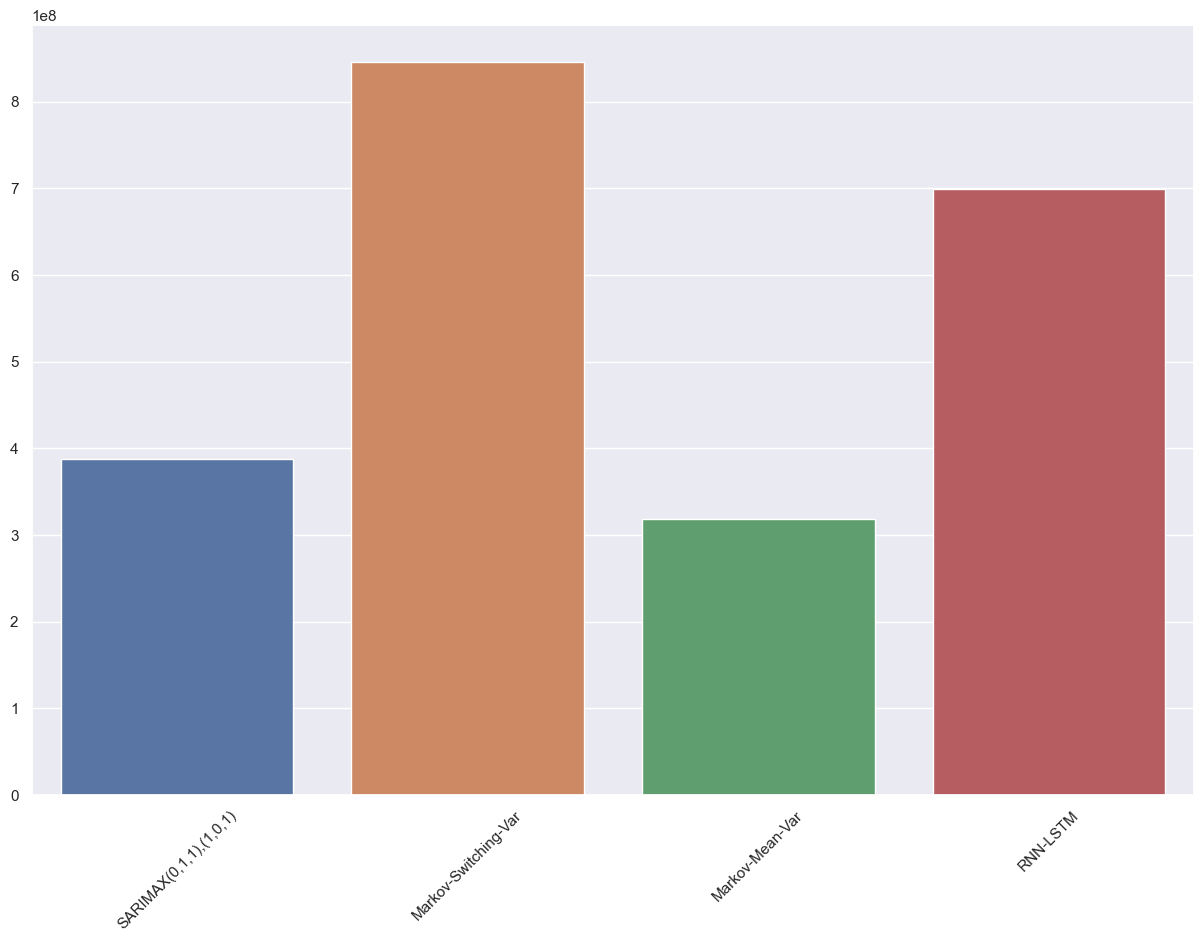

In [162]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_rmse_prev)
_ = plt.xticks(rotation=45)

#### MAPE dos Dados Previstos

In [163]:
df_mape_prev = df_mape[['SARIMAX(0,1,1),(1,0,1)',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM']]

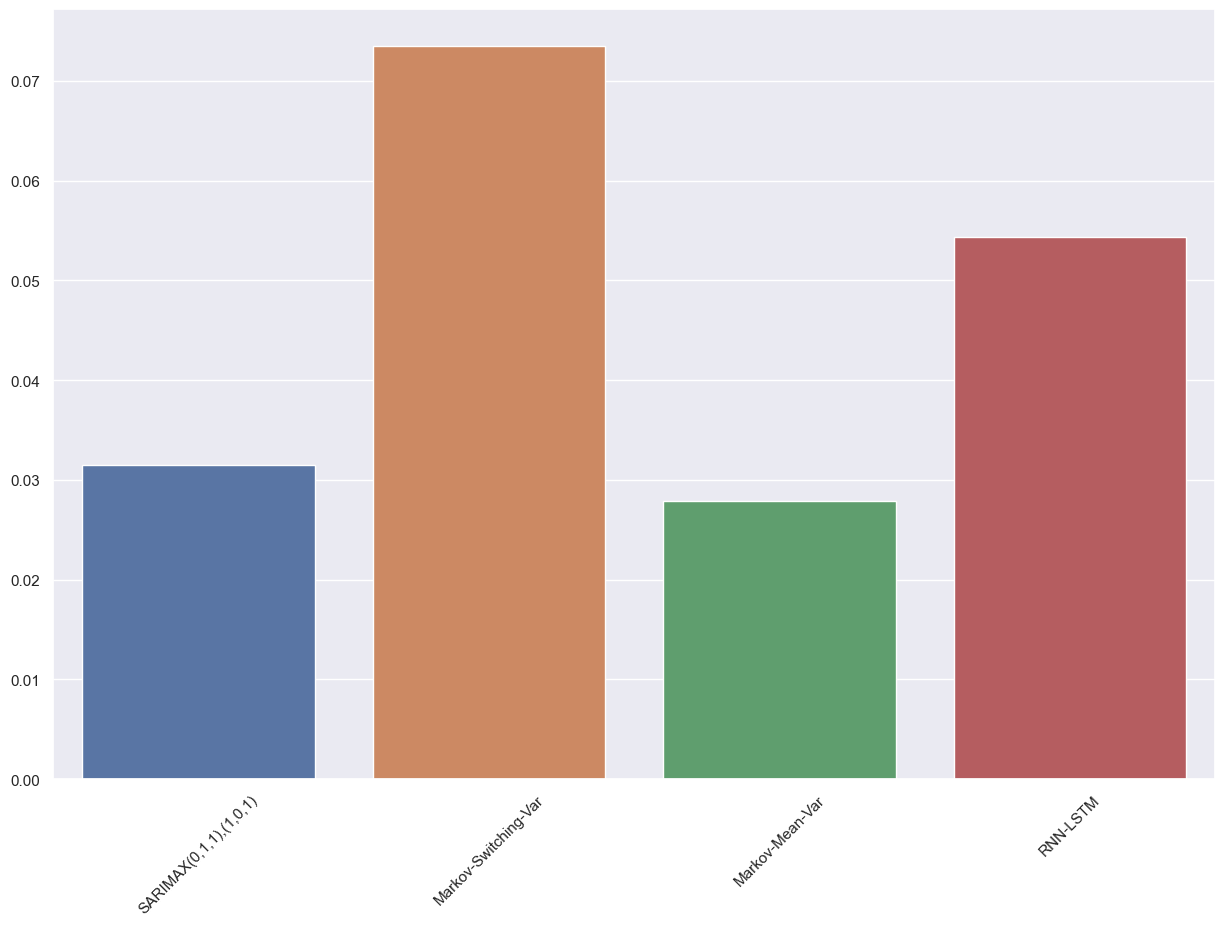

In [164]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_mape_prev)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [165]:
df_rmse_prev.index = ['RMSE']
df_mape_prev.index = ['MAPE']

In [166]:
df_metricas = df_rmse_prev.copy()
df_metricas = df_metricas.append(df_mape_prev)
df_metricas

SARIMAX(0,1,1),(1,0,1)  Markov-Switching-Var  Markov-Mean-Var  \
RMSE            3.871989e+08          8.461725e+08     3.182631e+08   
MAPE            3.152838e-02          7.353159e-02     2.784445e-02   

          RNN-LSTM  
RMSE  6.993983e+08  
MAPE  5.437897e-02

In [167]:
df_metricas.transpose().to_excel('./metricas_multi_2013.xlsx', index_label='metrica')

In [168]:
print(df_metricas.transpose().to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
SARIMAX(0,1,1),(1,0,1) &  3.871989e+08 &  0.031528 \\
Markov-Switching-Var   &  8.461725e+08 &  0.073532 \\
Markov-Mean-Var        &  3.182631e+08 &  0.027844 \\
RNN-LSTM               &  6.993983e+08 &  0.054379 \\
\bottomrule
\end{tabular}



In [169]:
print(df_prev_prev['2013-01-01':'2013-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2013-01-01 &    2013-02-01 &    2013-03-01 &    2013-04-01 \\
\midrule
SARIMAX(0,1,1),(1,0,1) &  9.386985e+09 &  8.819138e+09 &  9.572178e+09 &  1.000040e+10 \\
Markov-Switching-Var   &  9.525869e+09 &  8.815371e+09 &  8.984973e+09 &  9.726540e+09 \\
Markov-Mean-Var        &  9.562413e+09 &  8.813939e+09 &  9.043371e+09 &  9.486146e+09 \\
RNN-LSTM               &  8.742387e+09 &  8.345878e+09 &  8.735536e+09 &  8.988796e+09 \\
Real                   &  8.799359e+09 &  8.690433e+09 &  8.698445e+09 &  9.446984e+09 \\
\bottomrule
\end{tabular}



In [170]:
print(df_prev_prev['2013-05-01':'2013-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2013-05-01 &    2013-06-01 &    2013-07-01 &    2013-08-01 \\
\midrule
SARIMAX(0,1,1),(1,0,1) &  9.528873e+09 &  9.597817e+09 &  9.645359e+09 &  9.804562e+09 \\
Markov-Switching-Var   &  9.786724e+09 &  9.881905e+09 &  1.014745e+10 &  1.040904e+10 \\
Markov-Mean-Var        &  9.302260e+09 &  9.261482e+09 &  9.301341e+09 &  9.437837e+09 \\
RNN-LSTM               &  9.015341e+09 &  8.904838e+09 &  9.242751e+09 &  9.291536e+09 \\
Real                   &  9.497989e+09 &  9.133477e+09 &  9.657129e+09 &  9.604407e+09 \\
\bottomrule
\end{tabular}



In [171]:
print(df_prev_prev['2013-09-01':'2013-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2013-09-01 &    2013-10-01 &    2013-11-01 &    2013-12-01 \\
\midrule
SARIMAX(0,1,1),(1,0,1) &  1.000559e+10 &  1.032016e+10 &  9.967158e+09 &  1.091537e+10 \\
Markov-Switching-Var   &  1.085945e+10 &  1.136375e+10 &  1.148946e+10 &  1.191445e+10 \\
Markov-Mean-Var        &  9.804901e+09 &  1.009375e+10 &  1.001373e+10 &  1.047089e+10 \\
RNN-LSTM               &  9.156719e+09 &  9.321944e+09 &  9.108919e+09 &  9.061785e+09 \\
Real                   &  1.011536e+10 &  1.020979e+10 &  9.712795e+09 &  1.076762e+10 \\
\bottomrule
\end{tabular}



In [172]:
df_prev_prev.to_excel('./previsoes_multi_2013.xlsx', index_label='mes_ano')